# Regression and Classification with the Ames Housing Data

---

**Challenge**

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

**NB**: A Linear Regression was used throughout the project for simplicity but any other regression algorithm could have been used.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# Set viewing settings for outputs
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# View the head of the data
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0         NaN     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0          0            0         0    NaN   NaN         NaN        0       2    2008       WD        Normal     208500
1   2          20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0          0            0         0    NaN   NaN         NaN        0       5    2007       WD        Normal     181500
2   3          60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0          0            0         0    NaN   NaN         NaN        0       9    2008       WD        Normal     223500
3   4          70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf           0        540          756   

In [5]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [6]:
# Only keep residential properties
residential_zones = ['FV','RH','RL','RP','RM']
house = house[house['MSZoning'].isin(residential_zones)==True]

In [7]:
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [8]:
# Identify any strange data types that don't match with expectations
# This would potentially highlight columns required for data cleaning
house.dtypes
# After reviewing the data types all columns appear to have the correct data type

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [9]:
# See an overview of the data - used for (amongst other things) determining if zeros already exist in columns
house.describe(include='all')

Id   MSSubClass MSZoning  LotFrontage        LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond    YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1   BsmtFinSF1 BsmtFinType2   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional   Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish   GarageCars   GarageArea GarageQual GarageCond PavedDrive   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea PoolQC  Fence MiscFeature       MiscVal       MoSold       YrSold SaleType SaleCondition      SalePrice
count   1450.000000  1450.000000     1450  1191.000000    1450.000000   1450    89     1450        1450      1450      1450      1450         1450       1450       1450     1450       1450  1450.000000  1450.000000  1450.000000   1450.000000      1450     1450        1450        1450       1442  1442.000000      1450      1450       1450     1413     1413         1412         1413  1450.000000         1412  1450.000000  1450.000000  1450.000000    1450      1450       1450       1449  1450.000000  1450.000000   1450.000000  1450.000000   1450.000000   1450.000000  1450.000000  1450.000000   1450.000000   1450.000000        1450   1450.000000       1450  1450.000000         769       1371  1371.000000         1371  1450.000000  1450.000000       1371       1371       1450  1450.000000  1450.000000    1450.000000  1450.000000  1450.000000  1450.000000      7    278          52   1450.000000  1450.000000  1450.000000     1450          1450    1450.000000
unique          NaN          NaN        4          NaN            NaN      2     2        4           4         2         5         3           25          9          8        5          8          NaN          NaN          NaN           NaN         6        8          15          16          4          NaN         4         5          6        4        4            4            6          NaN            6          NaN          NaN          NaN       6         5          2          5          NaN          NaN           NaN          NaN           NaN           NaN          NaN          NaN           NaN           NaN           4           NaN          7          NaN           5          6          NaN            3          NaN          NaN          5          5          3          NaN          NaN            NaN          NaN          NaN          NaN      3      4           4           NaN          NaN          NaN        9             6            NaN
top             NaN          NaN       RL          NaN            NaN   Pave  Grvl      Reg         Lvl    AllPub    Inside       Gtl        NAmes       Norm       Norm     1Fam     1Story          NaN          NaN          NaN           NaN     Gable  CompShg     VinylSd     VinylSd       None          NaN        TA        TA      PConc       TA       TA           No          Unf          NaN          Unf          NaN          NaN          NaN    GasA        Ex          Y      SBrkr          NaN          NaN           NaN          NaN           NaN           NaN          NaN          NaN           NaN           NaN          TA           NaN        Typ          NaN          Gd     Attchd          NaN          Unf          NaN          NaN         TA         TA          Y          NaN          NaN            NaN          NaN          NaN          NaN     Gd  MnPrv        Shed           NaN          NaN          NaN       WD        Normal            NaN
freq            NaN          NaN     1151          NaN            NaN   1446    50      916        1305      1449      1044      1375          225       

In [10]:
# Print list of columns and number of nulls (where nulls > 0)
null_cols = house.isnull().sum()
null_cols[null_cols>0]

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

In [11]:
# Used for data discovery in determining what to do with nulls
house[house['BsmtExposure'].isnull()==True]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
17      18          90       RL         72.0    10791   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl       Sawyer       Norm       Norm   Duplex     1Story            4            5       1967          1967     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA       Slab      NaN      NaN          NaN          NaN           0          NaN           0          0            0    GasA        TA          Y      SBrkr      1296         0             0       1296             0             0         2         0             2             2          TA             6        Typ           0         NaN    CarPort       1967.0          Unf           2         516         TA         TA          Y           0            0              0          0            0         0    NaN    NaN        Shed      500      10    2006       WD        Normal      90000
39      40          90       RL         65.0     6040   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      Edwards       Norm       Norm   Duplex     1Story            4            5       1955          1955     Gable  CompShg     AsbShng     Plywood       None         0.0        TA        TA      PConc      NaN      NaN          NaN          NaN           0          NaN           0          0            0    GasA        TA          N      FuseP      1152         0             0       1152             0             0         2         0             2             2          Fa             6        Typ           0         NaN        NaN          NaN          NaN           0           0        NaN        NaN          N           0            0              0          0            0         0    NaN    NaN         NaN        0       6    2008       WD       AdjLand      82000
90      91          20       RL         60.0     7200   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl        NAmes       Norm       Norm     1Fam     1Story            4            5       1950          1950     Gable  CompShg     BrkFace     Wd Sdng       None         0.0        TA        TA       Slab      NaN      NaN          NaN          NaN           0          NaN           0          0            0    GasA        TA          Y      FuseA      1040         0             0       1040             0             0         1         0             2             1          TA             4        Typ           0         NaN     Detchd       1950.0          Unf           2         420         TA         TA          Y           0           29              0          0            0         0    NaN    NaN         NaN        0       7    2006       WD        Normal     109900
102    103          90       RL         64.0     7018   Pave   NaN      Reg         Bnk    AllPub    Inside       Gtl      SawyerW       Norm       Norm   Duplex     1Story            5            5       1979          1979     Gable  CompShg     HdBoard     HdBoard       None         0.0        TA        Fa       Slab      NaN      NaN          NaN          NaN           0          NaN           0   

In [12]:
# Used for data discovery in determining what to do with nulls
house['Neighborhood'].value_counts(dropna=False)

NAmes      225
CollgCr    150
OldTown    112
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
ClearCr     28
IDOTRR      28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

### Assumptions made re replacing nulls

Lot frontage: If null then no part of the lot is fronted by the street - replace NaN by 0 (Supported as no existing zero values in data)

Alley: If null then no Alley access - replace NaN with 'No alley access'

MasVnrType: If null then no masonry veneer as Exterior1st and Exterior2nd are Vinyl, Wood, Stone or Cement - replace NaN with 'None' to be consistent with other values in that column

MasVnrArea: Only null if MasVnrType is null - replace NaN with 0

Bsmt(all): Only null if TotalBsmtSF = 0 - replace NaN with 'No basement'

BsmtFinType1: Conflict for 1 row between Unfinished basement and BsmtExposure = NaN. Only 1 row - drop
    
Electrical: Only a single null - drop row

FireplaceQu: Only null if Fireplaces = 0 - replace NaN with 'No fireplace'

GarageType,GarageFinish,GarageQual,GarageCond: Only null if GarageArea = 0 - replace NaN with 'No garage'

GarageYrBuilt: Only null if GarageArea = 0 - delete column as neither 0 nor a string would work and age of garage is unlikely to have a significant impact on the price of a house

PoolQC: Only null if pool area = 0 - replace NaN with 'No pool'

Fence: Assume if no fence quality then no fence - replace NaN with 'No fence'

MiscFeature: Only NaN if MiscVal = 0 - replace NaN with 'No misc feature'

In [13]:
# Drop conflicted basement row - 1 row
drop_index = house[(house['BsmtFinType1']=='Unf')&(house['BsmtExposure'].isnull()==True)].index

for i in drop_index:
    house.drop(i,inplace=True)
    
# Drop Electrical NaN - 1 row
house.dropna(subset=['Electrical'],inplace=True)

In [14]:
null_replacements = {'LotFrontage':0,
                    'Alley':'NA',
                    'MasVnrType':'None',
                    'MasVnrArea':0,
                    'BsmtQual':'NA',
                    'BsmtCond':'NA',
                    'BsmtExposure':'NA',
                    'BsmtFinType1':'NA',
                    'BsmtFinType2':'NA',
                    'FireplaceQu':'NA',
                    'GarageType':'NA',
                    'GarageFinish':'NA',
                    'GarageQual':'NA',
                    'GarageCond':'NA',
                    'PoolQC':'NA',
                    'Fence':'NA',
                    'MiscFeature':'NA'
                    }


for key,value in null_replacements.items():
    house[key].replace(np.nan,value,inplace=True)

In [15]:
# Drop GarageYrBuilt
house.drop('GarageYrBlt',axis=1,inplace=True)

In [16]:
# Print list of columns and number of nulls (where nulls > 0)
null_cols = house.isnull().sum()
null_cols[null_cols>0]

Series([], dtype: int64)

In [17]:
# Understand the data, including the number of null values by column
house.describe(include='all')

Id   MSSubClass MSZoning  LotFrontage        LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond    YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1   BsmtFinSF1 BsmtFinType2   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional   Fireplaces FireplaceQu GarageType GarageFinish   GarageCars   GarageArea GarageQual GarageCond PavedDrive   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea PoolQC Fence MiscFeature       MiscVal       MoSold       YrSold SaleType SaleCondition      SalePrice
count   1448.000000  1448.000000     1448  1448.000000    1448.000000   1448  1448     1448        1448      1448      1448      1448         1448       1448       1448     1448       1448  1448.000000  1448.000000  1448.000000   1448.000000      1448     1448        1448        1448       1448  1448.000000      1448      1448       1448     1448     1448         1448         1448  1448.000000         1448  1448.000000  1448.000000  1448.000000    1448      1448       1448       1448  1448.000000  1448.000000   1448.000000  1448.000000   1448.000000   1448.000000  1448.000000  1448.000000   1448.000000   1448.000000        1448   1448.000000       1448  1448.000000        1448       1448         1448  1448.000000  1448.000000       1448       1448       1448  1448.000000  1448.000000    1448.000000  1448.000000  1448.000000  1448.000000   1448  1448        1448   1448.000000  1448.000000  1448.000000     1448          1448    1448.000000
unique          NaN          NaN        4          NaN            NaN      2     3        4           4         2         5         3           25          9          8        5          8          NaN          NaN          NaN           NaN         6        8          15          16          4          NaN         4         5          6        5        5            5            7          NaN            7          NaN          NaN          NaN       6         5          2          5          NaN          NaN           NaN          NaN           NaN           NaN          NaN          NaN           NaN           NaN           4           NaN          7          NaN           6          7            4          NaN          NaN          6          6          3          NaN          NaN            NaN          NaN          NaN          NaN      4     5           5           NaN          NaN          NaN        9             6            NaN
top             NaN          NaN       RL          NaN            NaN   Pave    NA      Reg         Lvl    AllPub    Inside       Gtl        NAmes       Norm       Norm     1Fam     1Story          NaN          NaN          NaN           NaN     Gable  CompShg     VinylSd     VinylSd       None          NaN        TA        TA      PConc       TA       TA           No          Unf          NaN          Unf          NaN          NaN          NaN    GasA        Ex          Y      SBrkr          NaN          NaN           NaN          NaN           NaN           NaN          NaN          NaN           NaN           NaN          TA           NaN        Typ          NaN          NA     Attchd          Unf          NaN          NaN         TA         TA          Y          NaN          NaN            NaN          NaN          NaN          NaN     NA    NA          NA           NaN          NaN          NaN       WD        Normal            NaN
freq            NaN          NaN     1149          NaN            NaN   1444  1359      915        1303      1447      1042      1373          225       1250       1434     1209        722          NaN        

## Determine Fixed and Variable Characteristics

### Assumptions used when determining if something is fixed or variable

- No extensions or structural work will be added to the property to increase the number of rooms or change the overall structure of the house
- No changes to room purpose (e.g. additional bathrooms) will be done
- All exterior coverings on the house are variable
- All utility types are variable, except external utilities
- Quality of interior is variable
- Number of rooms above grade is fixed
- Garage Type is fixed
- Drive pave type is variable
- Wood deck area is variable
- Porch size is fixed
- Pool size is fixed



In [18]:
characteristic_dict = {'Id': {'FixVar': 'ID', 'Dummy': 'N'},
                     'MSSubClass': {'FixVar': 'F', 'Dummy': 'Y'},
                     'MSZoning': {'FixVar': 'F', 'Dummy': 'Y'},
                     'LotFrontage': {'FixVar': 'F', 'Dummy': 'N'},
                     'LotArea': {'FixVar': 'F', 'Dummy': 'N'},
                     'Street': {'FixVar': 'F', 'Dummy': 'Y'},
                     'Alley': {'FixVar': 'F', 'Dummy': 'Y'},
                     'LotShape': {'FixVar': 'F', 'Dummy': 'Y'},
                     'LandContour': {'FixVar': 'F', 'Dummy': 'Y'},
                     'Utilities': {'FixVar': 'F', 'Dummy': 'Y'},
                     'LotConfig': {'FixVar': 'F', 'Dummy': 'Y'},
                     'LandSlope': {'FixVar': 'F', 'Dummy': 'Y'},
                     'Neighborhood': {'FixVar': 'F', 'Dummy': 'Y'},
                     'Condition1': {'FixVar': 'F', 'Dummy': 'Y'},
                     'Condition2': {'FixVar': 'F', 'Dummy': 'Y'},
                     'BldgType': {'FixVar': 'F', 'Dummy': 'Y'},
                     'HouseStyle': {'FixVar': 'F', 'Dummy': 'Y'},
                     'OverallQual': {'FixVar': 'V', 'Dummy': 'N'},
                     'OverallCond': {'FixVar': 'V', 'Dummy': 'N'},
                     'YearBuilt': {'FixVar': 'F', 'Dummy': 'N'},
                     'YearRemodAdd': {'FixVar': 'F', 'Dummy': 'N'},
                     'RoofStyle': {'FixVar': 'F', 'Dummy': 'Y'},
                     'RoofMatl': {'FixVar': 'V', 'Dummy': 'Y'},
                     'Exterior1st': {'FixVar': 'V', 'Dummy': 'Y'},
                     'Exterior2nd': {'FixVar': 'V', 'Dummy': 'Y'},
                     'MasVnrType': {'FixVar': 'V', 'Dummy': 'Y'},
                     'MasVnrArea': {'FixVar': 'V', 'Dummy': 'N'},
                     'ExterQual': {'FixVar': 'V', 'Dummy': 'N'},
                     'ExterCond': {'FixVar': 'V', 'Dummy': 'N'},
                     'Foundation': {'FixVar': 'F', 'Dummy': 'Y'},
                     'BsmtQual': {'FixVar': 'F', 'Dummy': 'N'},
                     'BsmtCond': {'FixVar': 'V', 'Dummy': 'N'},
                     'BsmtExposure': {'FixVar': 'F', 'Dummy': 'N'},
                     'BsmtFinType1': {'FixVar': 'V', 'Dummy': 'N'},
                     'BsmtFinSF1': {'FixVar': 'V', 'Dummy': 'N'},
                     'BsmtFinType2': {'FixVar': 'V', 'Dummy': 'N'},
                     'BsmtFinSF2': {'FixVar': 'V', 'Dummy': 'N'},
                     'BsmtUnfSF': {'FixVar': 'V', 'Dummy': 'N'},
                     'TotalBsmtSF': {'FixVar': 'F', 'Dummy': 'N'},
                     'Heating': {'FixVar': 'V', 'Dummy': 'Y'},
                     'HeatingQC': {'FixVar': 'V', 'Dummy': 'N'},
                     'CentralAir': {'FixVar': 'V', 'Dummy': 'Y'},
                     'Electrical': {'FixVar': 'V', 'Dummy': 'Y'},
                     '1stFlrSF': {'FixVar': 'F', 'Dummy': 'N'},
                     '2ndFlrSF': {'FixVar': 'F', 'Dummy': 'N'},
                     'LowQualFinSF': {'FixVar': 'V', 'Dummy': 'N'},
                     'GrLivArea': {'FixVar': 'F', 'Dummy': 'N'},
                     'BsmtFullBath': {'FixVar': 'F', 'Dummy': 'N'},
                     'BsmtHalfBath': {'FixVar': 'F', 'Dummy': 'N'},
                     'FullBath': {'FixVar': 'F', 'Dummy': 'N'},
                     'HalfBath': {'FixVar': 'F', 'Dummy': 'N'},
                     'BedroomAbvGr': {'FixVar': 'F', 'Dummy': 'N'},
                     'KitchenAbvGr': {'FixVar': 'F', 'Dummy': 'N'},
                     'KitchenQual': {'FixVar': 'V', 'Dummy': 'N'},
                     'TotRmsAbvGrd': {'FixVar': 'F', 'Dummy': 'N'},
                     'Functional': {'FixVar': 'V', 'Dummy': 'Y'},
                     'Fireplaces': {'FixVar': 'F', 'Dummy': 'N'},
                     'FireplaceQu': {'FixVar': 'V', 'Dummy': 'N'},
                     'GarageType': {'FixVar': 'F', 'Dummy': 'Y'},
                     'GarageFinish': {'FixVar': 'V', 'Dummy': 'N'},
                     'GarageCars': {'FixVar': 'F', 'Dummy': 'N'},
                     'GarageArea': {'FixVar': 'F', 'Dummy': 'N'},
                     'GarageQual': {'FixVar': 'V', 'Dummy': 'N'},
                     'GarageCond': {'FixVar': 'V', 'Dummy': 'N'},
                     'PavedDrive': {'FixVar': 'V', 'Dummy': 'Y'},
                     'WoodDeckSF': {'FixVar': 'V', 'Dummy': 'N'},
                     'OpenPorchSF': {'FixVar': 'F', 'Dummy': 'N'},
                     'EnclosedPorch': {'FixVar': 'F', 'Dummy': 'N'},
                     '3SsnPorch': {'FixVar': 'F', 'Dummy': 'N'},
                     'ScreenPorch': {'FixVar': 'F', 'Dummy': 'N'},
                     'PoolArea': {'FixVar': 'F', 'Dummy': 'N'},
                     'PoolQC': {'FixVar': 'V', 'Dummy': 'N'},
                     'Fence': {'FixVar': 'V', 'Dummy': 'Y'},
                     'MiscFeature': {'FixVar': 'F', 'Dummy': 'Y'},
                     'MiscVal': {'FixVar': 'F', 'Dummy': 'N'},
                     'MoSold': {'FixVar': 'F', 'Dummy': 'Y'},
                     'YrSold': {'FixVar': 'F', 'Dummy': 'N'},
                     'SaleType': {'FixVar': 'F', 'Dummy': 'Y'},
                     'SaleCondition': {'FixVar': 'F', 'Dummy': 'Y'},
                     'SalePrice': {'FixVar': 'y', 'Dummy': 'N'}}

### Data conversion



In [19]:
qual_replacements = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
qual_cols_to_replace = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu',\
                       'GarageQual','GarageCond','PoolQC']
bsmt_fin_replacements = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
bsmt_fin_cols = ['BsmtFinType1','BsmtFinType2']

for col in qual_cols_to_replace:
    house[col] = house[col].map(qual_replacements)

for col in bsmt_fin_cols:
    house[col] = house[col].map(bsmt_fin_replacements)
    
bsmt_ex_replacements = {'Gd':3,'Av':2,'Mn':1,'No':0,'NA':0}
house['BsmtExposure'] = house['BsmtExposure'].map(bsmt_ex_replacements)
 
gar_fin_replacements = {'Fin':3,'RFn':2,'Unf':1,'NA':0}
house['GarageFinish'] = house['GarageFinish'].map(gar_fin_replacements)


## EDA Sales price

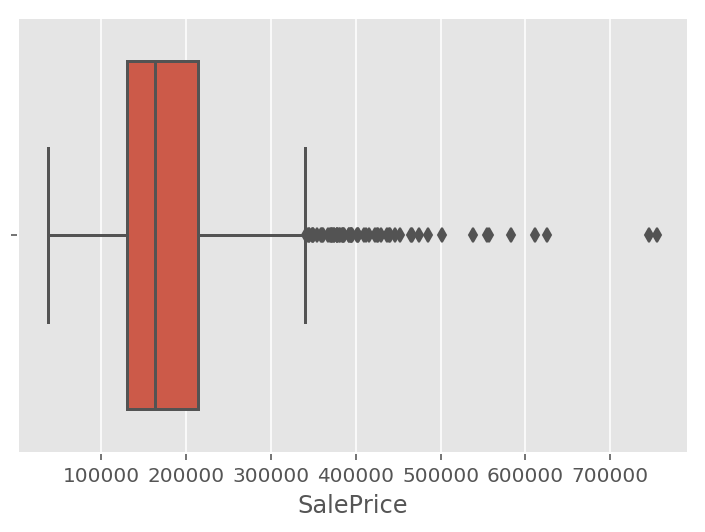

In [20]:
# Sales price outliers
sns.boxplot(house['SalePrice']);

### Outliers

There are some large outliers based on the standard definition of outliers. However, there are always going to be some high value properties and ideally the model will be able to predict these as well as standard house prices. I will leave them in and maybe try rescaling (e.g. using the log function)

## EDA for fixed variables

In [21]:
# Create a dataframe only containing fixed characteristics
fixed_cols = [key for key, value in characteristic_dict.items() if value['FixVar'] == 'F']

In [22]:
# Find number of potential dummies for fixed columns
# All numbers of dummies look acceptable - none exceed 25
fixed_cols_no_dummy = []
fixed_cols_to_dummy = []
for key,val in characteristic_dict.items():
    if key in fixed_cols:
        if val['Dummy'] == 'Y':
            fixed_cols_to_dummy.append(key)
            print('{0}\t {1}'.format(key,len(house[key].value_counts())))
        else:
            fixed_cols_no_dummy.append(key)

MSSubClass	 15
MSZoning	 4
Street	 2
Alley	 3
LotShape	 4
LandContour	 4
Utilities	 2
LotConfig	 5
LandSlope	 3
Neighborhood	 25
Condition1	 9
Condition2	 8
BldgType	 5
HouseStyle	 8
RoofStyle	 6
Foundation	 6
GarageType	 7
MiscFeature	 5
MoSold	 12
SaleType	 9
SaleCondition	 6


In [23]:
plt_cols=5
plt_rows=int(np.ceil(len(fixed_cols_no_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,4*plt_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
count=0
for col in fixed_cols_no_dummy:
    x,y = divmod(count,plt_cols)
    ax[x,y].scatter(x=col,y='SalePrice',data=house)
    ax[x,y].set_xlabel(col)
    ax[x,y].set_ylabel('SalePrice')
    ax[x,y].set_title(col)
    count+=1
    
plt.show()

There appears to be one consistent outlier - a house that has a large area but a low sales price. I will exclude this from the data for the model.

### Log SalePrice

A number of the plots seem to show a slight logarithmic correlation between sales price and the variable in question. The next set of charts investigate this.

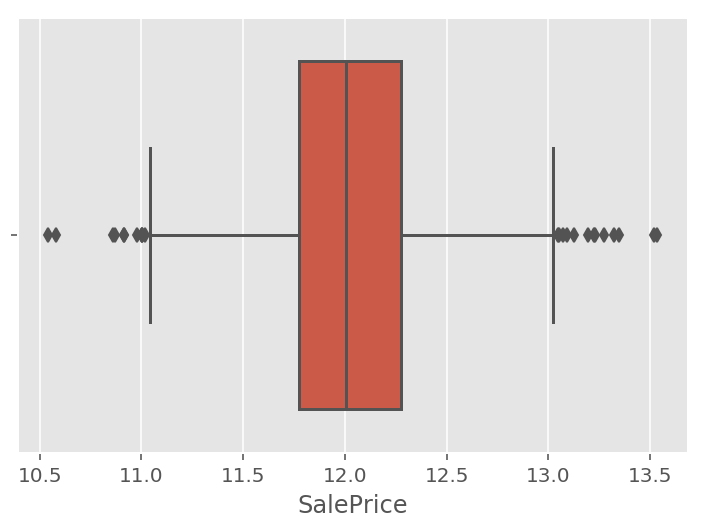

In [24]:
# Sales price outliers
sns.boxplot(np.log(house['SalePrice']));

Again, there appear to be outliers but they are spread both above and below the box and whiskers. This may imply using a log('SalePrice') may be more useful.

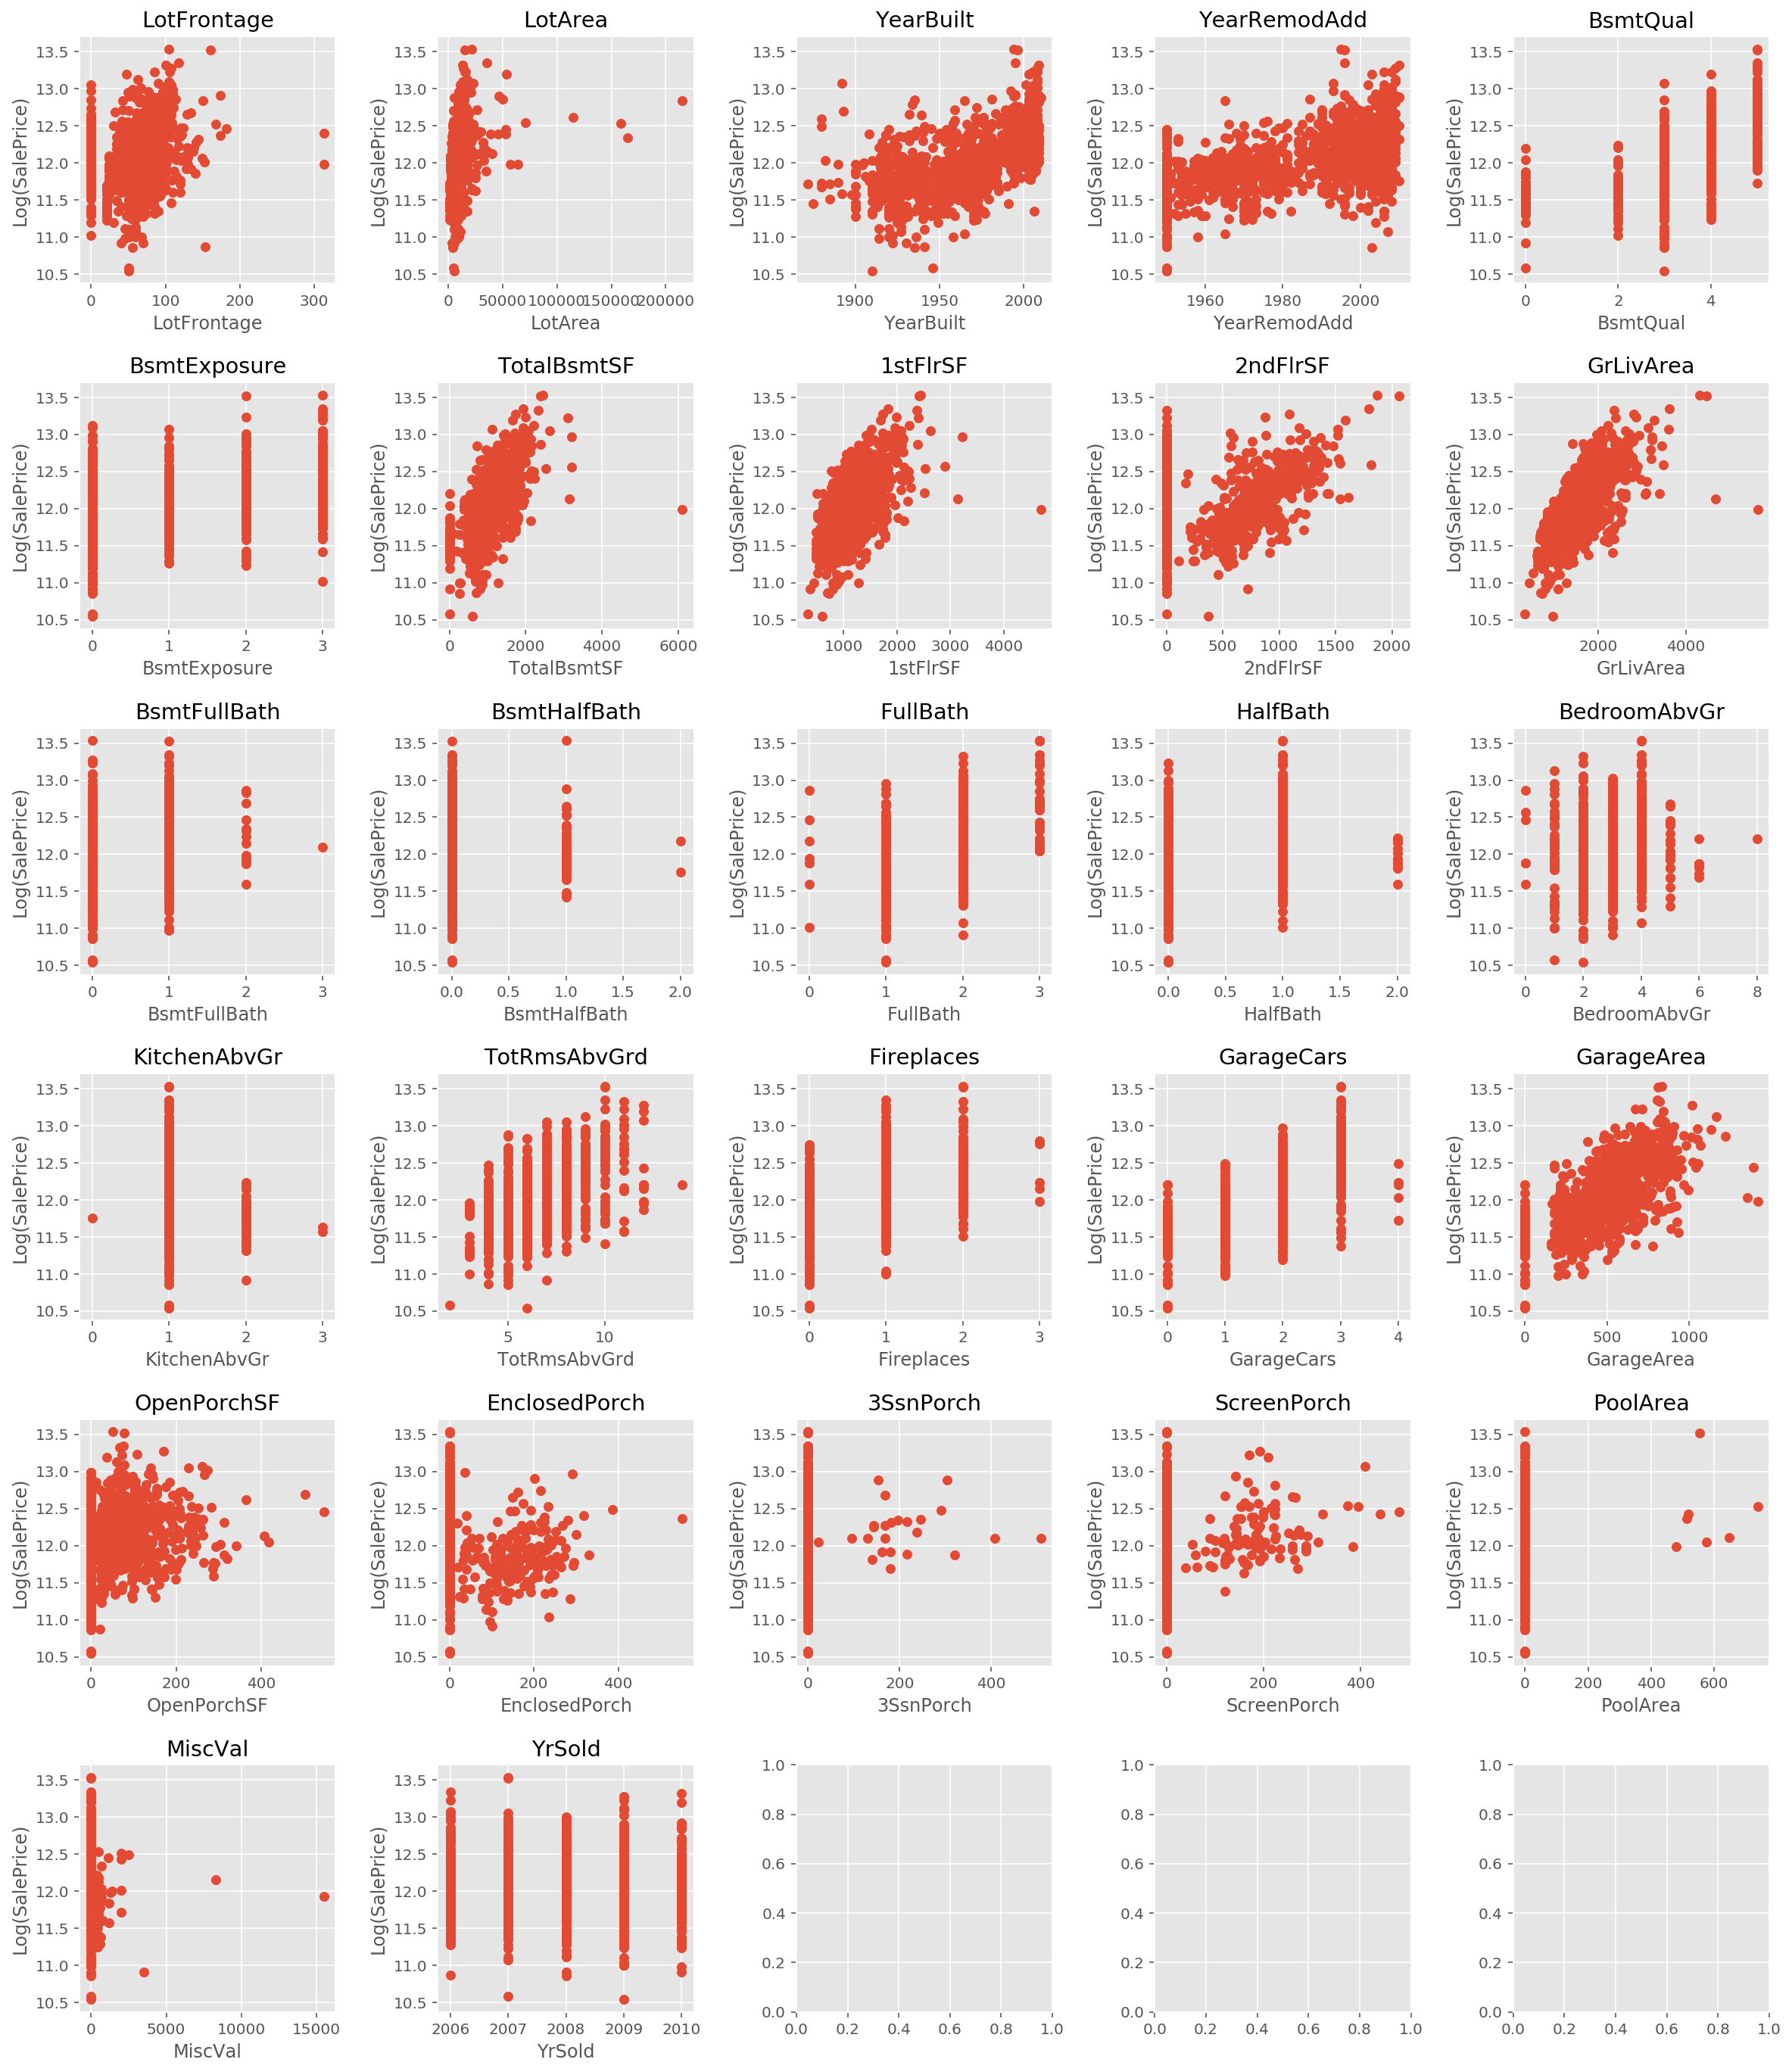

In [25]:
plt_cols=5
plt_rows=int(np.ceil(len(fixed_cols_no_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,4*plt_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
count=0
for col in fixed_cols_no_dummy:
    x,y = divmod(count,plt_cols)
    ax[x,y].scatter(x=house[col],y=np.log(house['SalePrice']))
    ax[x,y].set_xlabel(col)
    ax[x,y].set_ylabel('Log(SalePrice)')
    ax[x,y].set_title(col)
    count+=1
    
plt.show()

### Outliers

The outlier identified above still remains. I will exclude it from the data for the model training.

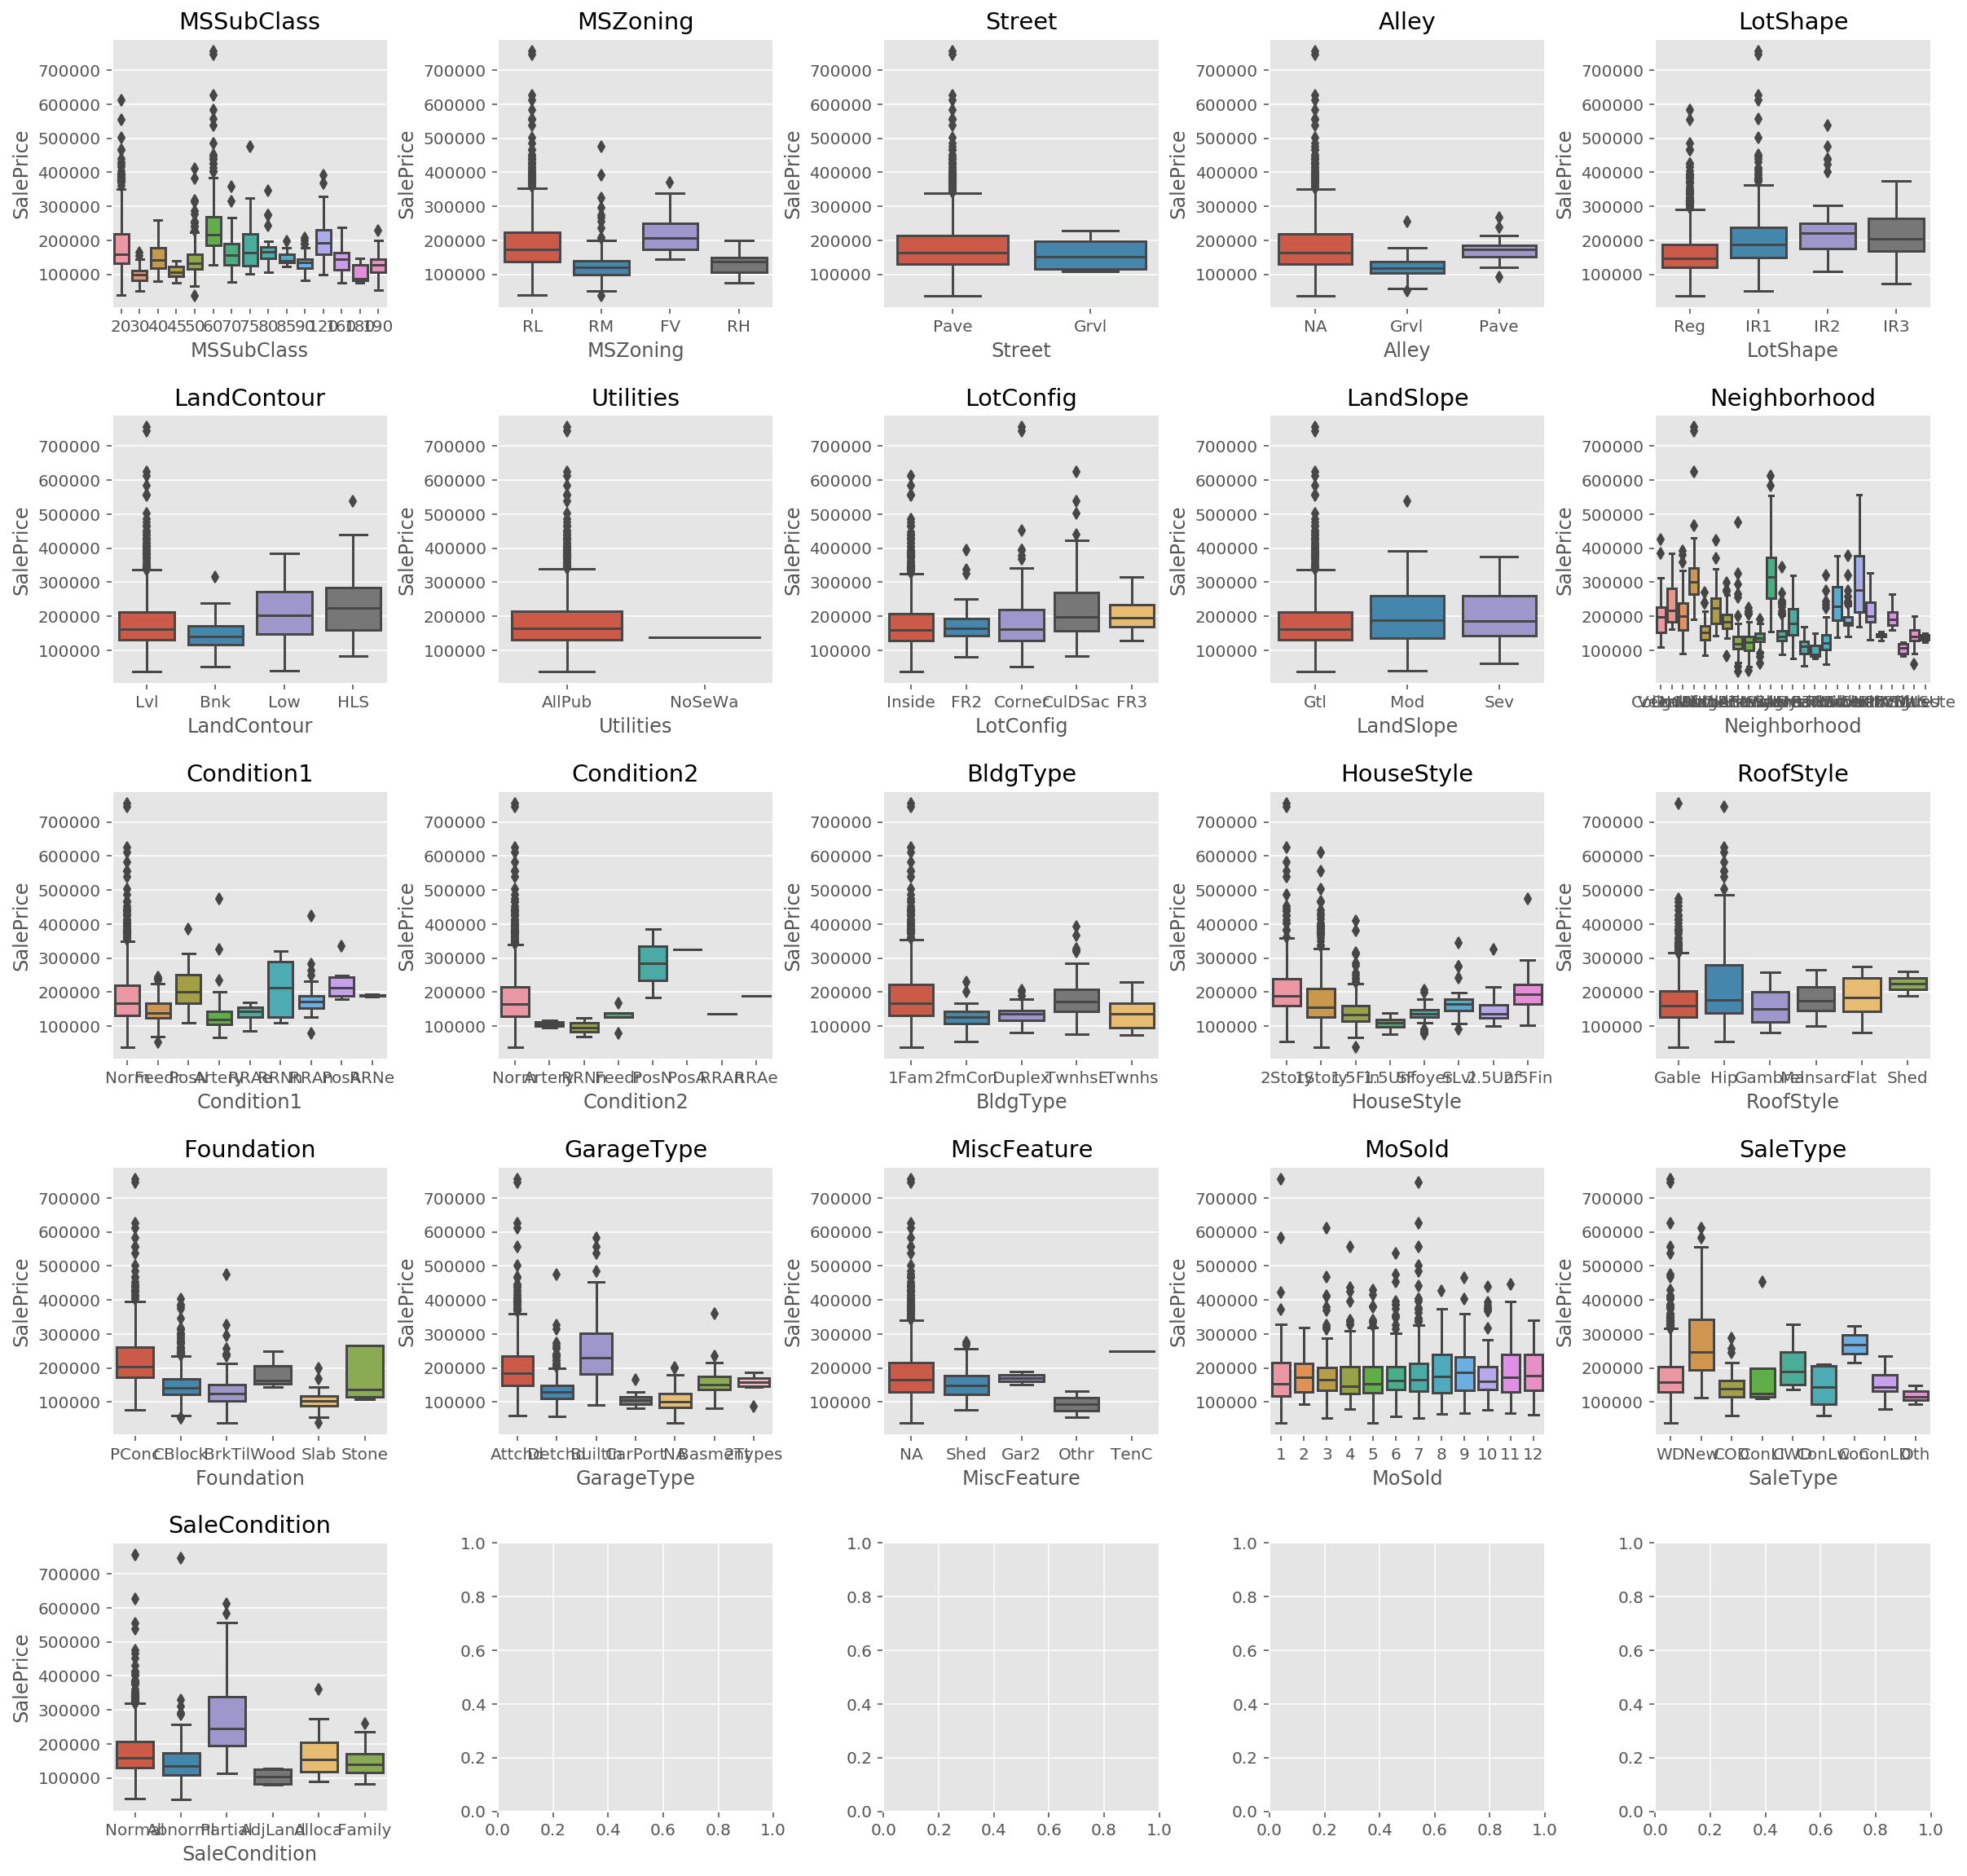

In [26]:
plt_cols=5
plt_rows=int(np.ceil(len(fixed_cols_to_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,4*plt_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
count=0
for col in fixed_cols_to_dummy:
    x,y = divmod(count,plt_cols)
    sns.boxplot(x=col,y='SalePrice', data=house,ax=ax[x,y])
    ax[x,y].set_title(col)
    count+=1
    
plt.show()

### Outliers

Based on the traditional definition of outliers there are a large number of outliers in the data for each individul factor. 

However, as there are a large number of factors not considered when looking at sale price against each inidividual factor in isolation, it may be useful to keep all the data for the first run of the model and review the distribution of the residuals to see if they are anything other than normal.

### Exclude outliers

In [27]:
# Basement square footage outlier
house = house[house['TotalBsmtSF'] <= 6000]

In [28]:
# Reset index after dropping rows
house.reset_index(drop=True, inplace=True)

## Prepare data

In [29]:
house_fix = house[fixed_cols].copy()
house_fix['SalePrice'] = np.log(house['SalePrice'])

X_fix = pd.get_dummies(house_fix,drop_first=True,columns=fixed_cols_to_dummy)

X_train_fix = X_fix[X_fix['YrSold']<2010].copy()
X_test_fix = X_fix[X_fix['YrSold']==2010].copy()

y = X_fix.pop('SalePrice')
y_train_fix = X_train_fix.pop('SalePrice')
y_test_fix = X_test_fix.pop('SalePrice')


In [30]:
kf = KFold(n_splits=8, shuffle=True, random_state=1)

## Model selection

### Attempt #1: no standardisation

Linear regression - no regularisation

In [31]:
lin_reg_model = LinearRegression()

lin_reg_model_cv_scores = cross_val_score(lin_reg_model, X_train_fix, y_train_fix, cv=kf)

lin_reg_model_cv_scores.mean()

0.8622815090948688

Linear regression - Lasso

In [32]:
lin_reg_lassocv_model = LassoCV(n_alphas=1000,cv=kf)

lin_reg_lassocv_model.fit(X_train_fix,y_train_fix)

lin_reg_lasso_model = Lasso(lin_reg_lassocv_model.alpha_)

lin_reg_lasso_model_cv_scores = cross_val_score(lin_reg_lasso_model, X_train_fix, y_train_fix, cv=kf)

lin_reg_lasso_model_cv_scores.mean()

0.7871602033618673

Linear regression - Ridge

In [33]:
alpha_range = np.logspace(-4, 4, 1000)

lin_reg_ridgecv_model = RidgeCV(alphas=alpha_range,cv=kf)

lin_reg_ridgecv_model.fit(X_train_fix,y_train_fix)

lin_reg_ridge_model = Ridge(lin_reg_ridgecv_model.alpha_)

lin_reg_ridge_model_cv_scores = cross_val_score(lin_reg_ridge_model, X_train_fix, y_train_fix, cv=kf)

lin_reg_ridge_model_cv_scores.mean()

0.8708621464346771

Linear regression - ElasticNet

In [34]:
l1_ratios = np.linspace(0.001, 1.0, 100)

lin_reg_elnetcv_model = ElasticNetCV(n_alphas=100,l1_ratio=l1_ratios,cv=kf)

lin_reg_elnetcv_model.fit(X_train_fix,y_train_fix)

lin_reg_elnet_model = ElasticNet(lin_reg_elnetcv_model.alpha_)

lin_reg_elnet_model_cv_scores = cross_val_score(lin_reg_elnet_model, X_train_fix, y_train_fix, cv=kf)

lin_reg_elnet_model_cv_scores.mean()

0.8050830029166314

### Attempt #2: with standardisation

In [35]:
scaler = StandardScaler()

X_train_fix_std = scaler.fit_transform(X_train_fix)
X_test_fix_std = scaler.transform(X_test_fix)

Linear regression - no regularisation

In [36]:
lin_reg_model_std = LinearRegression()

lin_reg_model_cv_std_scores = cross_val_score(lin_reg_model_std, X_train_fix_std, y_train_fix, cv=kf)

lin_reg_model_cv_std_scores.mean()

-1.0480335545430325e+23

Linear regression - Lasso

In [37]:
lin_reg_lassocv_model_std = LassoCV(n_alphas=1000,cv=kf)

lin_reg_lassocv_model_std.fit(X_train_fix_std,y_train_fix)

lin_reg_lasso_model_std = Lasso(lin_reg_lassocv_model_std.alpha_)

lin_reg_lasso_model_cv_std_scores = cross_val_score(lin_reg_lasso_model_std, X_train_fix_std, y_train_fix, cv=kf)

lin_reg_lasso_model_cv_std_scores.mean()

0.874059230551647

Linear regression - Ridge

In [38]:
alpha_range = np.logspace(-4, 4, 1000)

lin_reg_ridgecv_model_std = RidgeCV(alphas=alpha_range,cv=kf)

lin_reg_ridgecv_model_std.fit(X_train_fix_std,y_train_fix)

lin_reg_ridge_model_std = Ridge(lin_reg_ridgecv_model_std.alpha_)

lin_reg_ridge_model_cv_std_scores = cross_val_score(lin_reg_ridge_model_std, X_train_fix_std, y_train_fix, cv=kf)

lin_reg_ridge_model_cv_std_scores.mean()

0.8696935691295674

Linear regression - ElasticNet

In [39]:
l1_ratios = np.linspace(0.001, 1.0, 100)

lin_reg_elnetcv_model_std = ElasticNetCV(n_alphas=100,l1_ratio=l1_ratios,cv=kf)

lin_reg_elnetcv_model_std.fit(X_train_fix_std,y_train_fix)

lin_reg_elnet_model_std = ElasticNet(lin_reg_elnetcv_model_std.alpha_)

lin_reg_elnet_model_cv_std_scores = cross_val_score(lin_reg_elnet_model_std, X_train_fix_std, y_train_fix, cv=kf)

lin_reg_elnet_model_cv_std_scores.mean()

0.8163688363775361

In [40]:
print('LinReg with no standardisation:\t',lin_reg_model_cv_scores.mean())
print('Lasso with no standardisation:\t',lin_reg_lasso_model_cv_scores.mean())
print('Ridge with no standardisation:\t',lin_reg_ridge_model_cv_scores.mean())
print('ElNet with no standardisation:\t',lin_reg_elnet_model_cv_scores.mean())
print('LinReg with standardisation:\t',lin_reg_model_cv_std_scores.mean())
print('Lasso with standardisation:\t',lin_reg_lasso_model_cv_std_scores.mean())
print('Ridge with standardisation:\t',lin_reg_ridge_model_cv_std_scores.mean())
print('ElNet with standardisation:\t',lin_reg_elnet_model_cv_std_scores.mean())

LinReg with no standardisation:	 0.8622815090948688
Lasso with no standardisation:	 0.7871602033618673
Ridge with no standardisation:	 0.8708621464346771
ElNet with no standardisation:	 0.8050830029166314
LinReg with standardisation:	 -1.0480335545430325e+23
Lasso with standardisation:	 0.874059230551647
Ridge with standardisation:	 0.8696935691295674
ElNet with standardisation:	 0.8163688363775361


### Conclusion

The best model is the Linear Regression model with Lasso regularisation based on standardised data, closely followed by the Linear Regression model with Ridge regularisation with no standardised data.

Based on this I will use the Linear Regression model with Lasso regularisation based on standardised data.

### Testing generalisation of model

In [41]:
lin_reg_lasso_model_std.fit(X_test_fix_std,y_test_fix)

lin_reg_lasso_model_std_test_score = lin_reg_lasso_model_std.score(X_test_fix_std,y_test_fix)

lin_reg_lasso_model_std_test_score

0.9564442286892215

It appears that the model generalises very well, as the r^2 score is higher for the test data than for the training data.

## Fit selected model on whole dataset and determine residuals

In [42]:
X_fix_std = scaler.fit_transform(X_fix)

In [43]:
lin_reg_lasso_model_std.fit(X_fix_std,y)

lin_reg_lasso_model_std_score = lin_reg_lasso_model_std.score(X_fix_std,y)

lin_reg_lasso_model_std_score

0.9006180667237438

This is a very strong r^2 score for the whole data set. It implies this model is good at predicting house prices.

In [44]:
y_hat_fix_std = np.exp(lin_reg_lasso_model_std.predict(X_fix_std))

residuals_fix_std = np.exp(y).to_frame()

residuals_fix_std['y_hat_fix_std'] = y_hat_fix_std

residuals_fix_std['residual_fix_std'] = residuals_fix_std['SalePrice'] - residuals_fix_std['y_hat_fix_std']

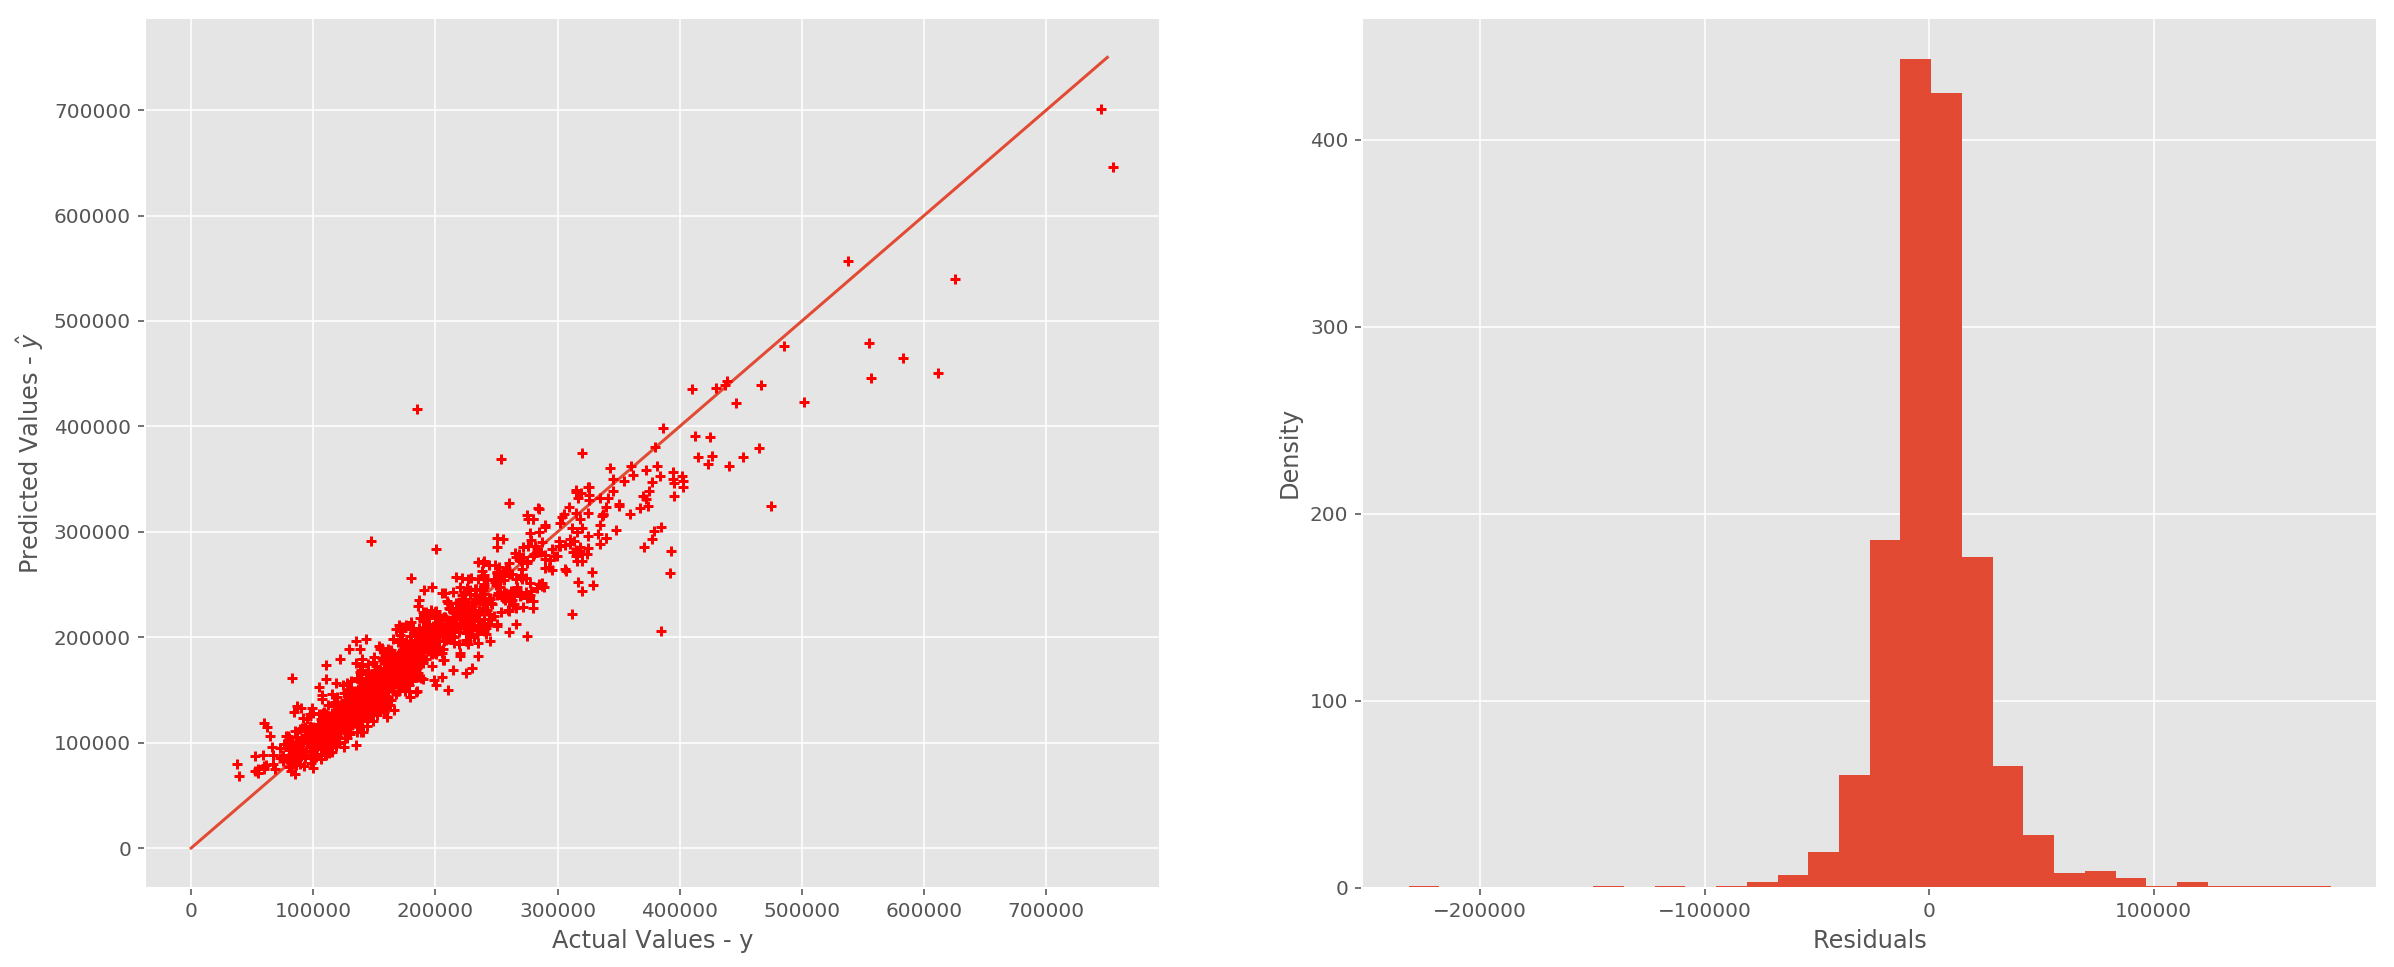

In [45]:
# Plot the predictions
x_plot = pd.DataFrame(np.linspace(0,750000))
y_plot = pd.DataFrame(np.linspace(0,750000))

fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].scatter(x='SalePrice', y='y_hat_fix_std', data=residuals_fix_std, s=30, c='r', marker='+', zorder=10)
ax[0].plot(x_plot,y_plot)
ax[0].set_ylabel("Predicted Values - $\hat{y}$")
ax[0].set_xlabel("Actual Values - y")

ax[1].hist(residuals_fix_std['residual_fix_std'],bins=30)
ax[1].set_xlabel("Residuals")
ax[1].set_ylabel("Density")

plt.show()

### Analysis

The left hand plot shows that the model is reasonably good at predicting house prices across the full spectrum of prices (albeit less good at the higher end of the market).

The distribution of the residuals is very close to a normal distribution, which implies the model is not being particularly skewed by the data.

Overall, including the high r^2 score, this is a strong model.

In [46]:
lin_reg_lasso_model_std.intercept_

12.030236493847955

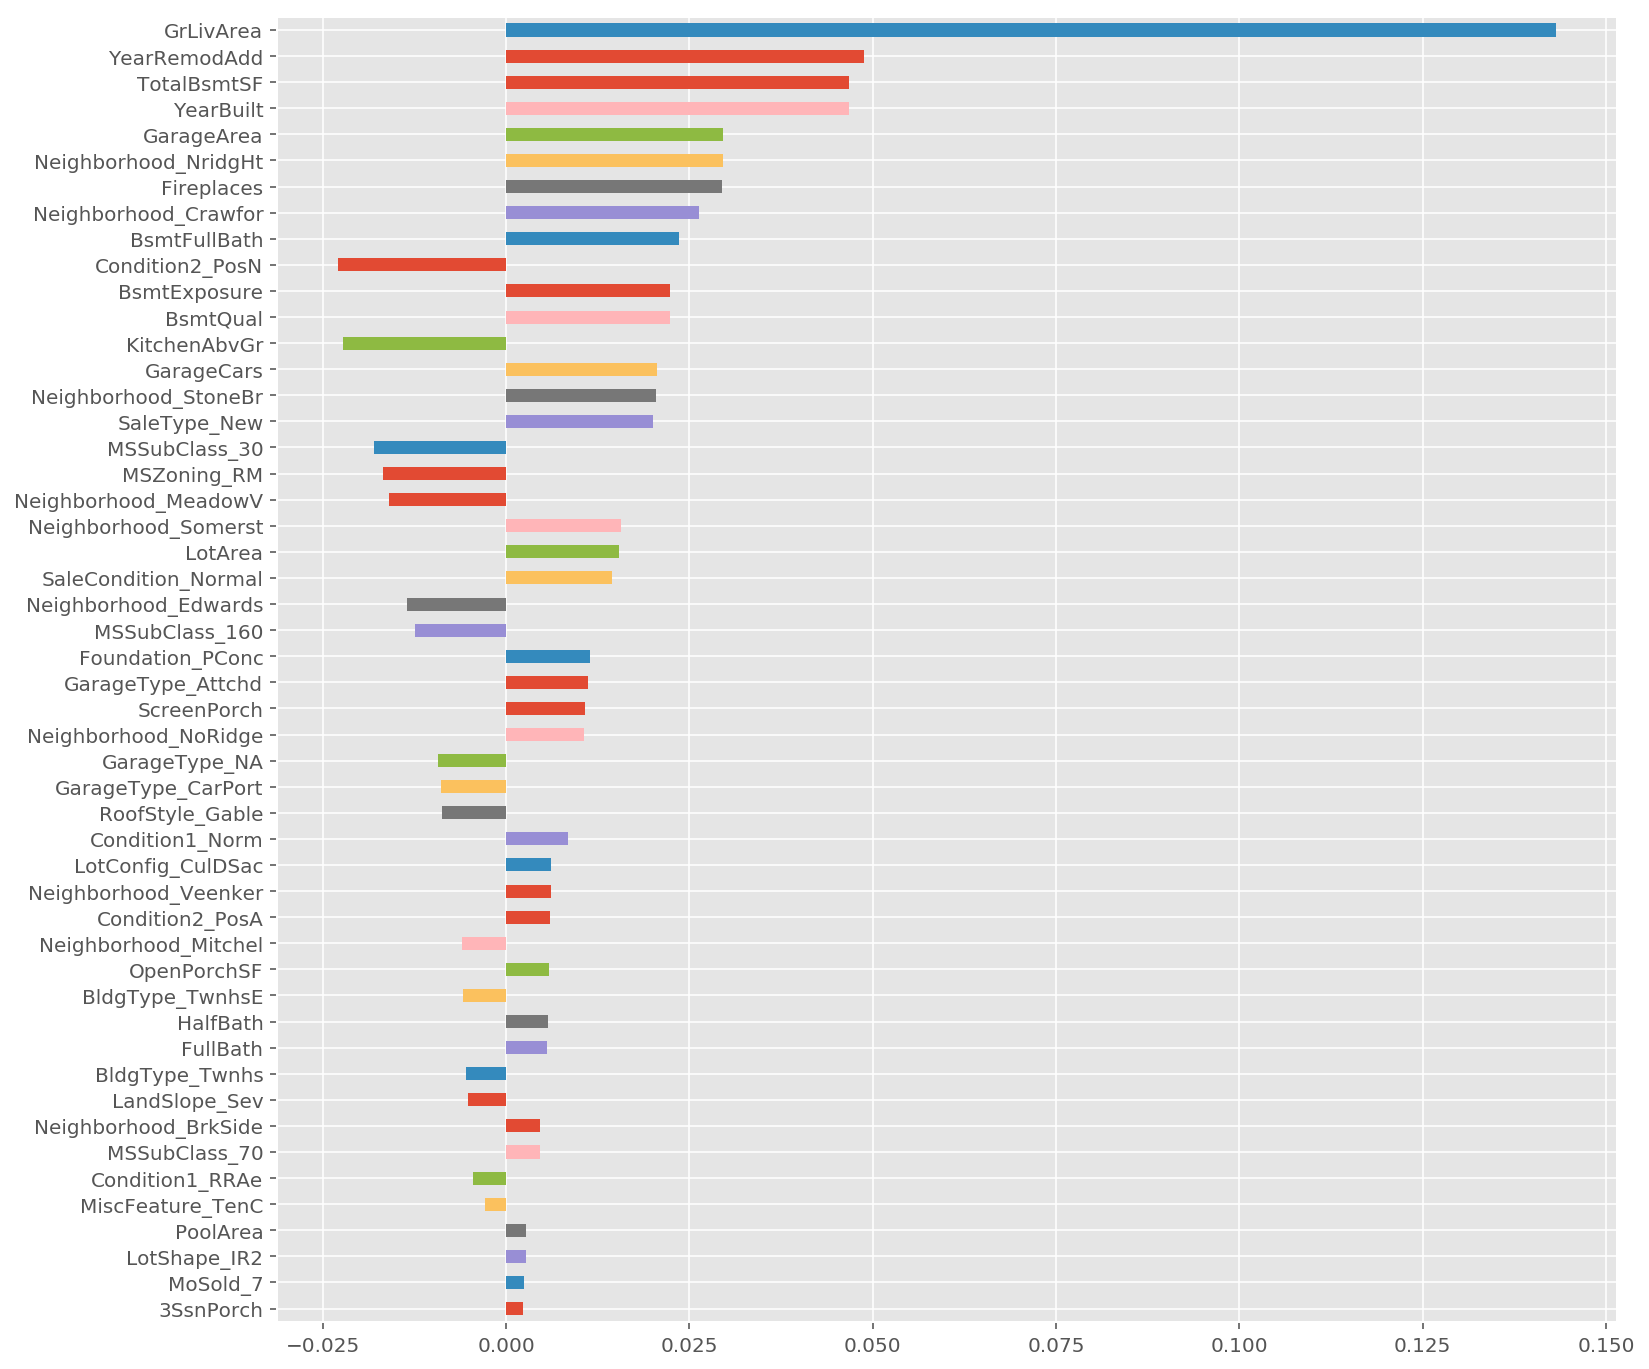

In [47]:
lin_reg_lasso_model_std_coef = pd.DataFrame(lin_reg_lasso_model_std.coef_, index=X_fix.columns, columns=['Coefs'])

lin_reg_lasso_model_std_coef['Abs_Coef'] = abs(lin_reg_lasso_model_std_coef['Coefs'])

lin_reg_lasso_model_std_coef.sort_values('Abs_Coef',ascending=True,inplace=True)

lin_reg_lasso_model_std_coef['Coefs'].tail(50).plot(kind='barh',figsize=(12,12),legend=False);

### Analysis

The largest factors for the model appear to be the size of the property, the age and the location. This is as expected based on a general understanding of the housing market.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [48]:
# Create a dataframe only containing variable characteristics
var_cols = [key for key, value in characteristic_dict.items() if value['FixVar'] == 'V']
house_var = house[var_cols].copy()

In [49]:
# Find number of potential dummies for variable columns
# All numbers of dummies look acceptable - none exceed 16
var_cols_no_dummy = []
var_cols_to_dummy = []
for key,val in characteristic_dict.items():
    if key in house_var.columns:
        if val['Dummy'] == 'Y':
            var_cols_to_dummy.append(key)
            print('{0}\t {1}'.format(key,len(house_var[key].value_counts())))
        else:
            var_cols_no_dummy.append(key)

RoofMatl	 7
Exterior1st	 15
Exterior2nd	 16
MasVnrType	 4
Heating	 6
CentralAir	 2
Electrical	 5
Functional	 7
PavedDrive	 3
Fence	 5


In [50]:
house_var['Residual'] = residuals_fix_std['residual_fix_std']
house_var['YrSold'] = house['YrSold']

## EDA Sales price

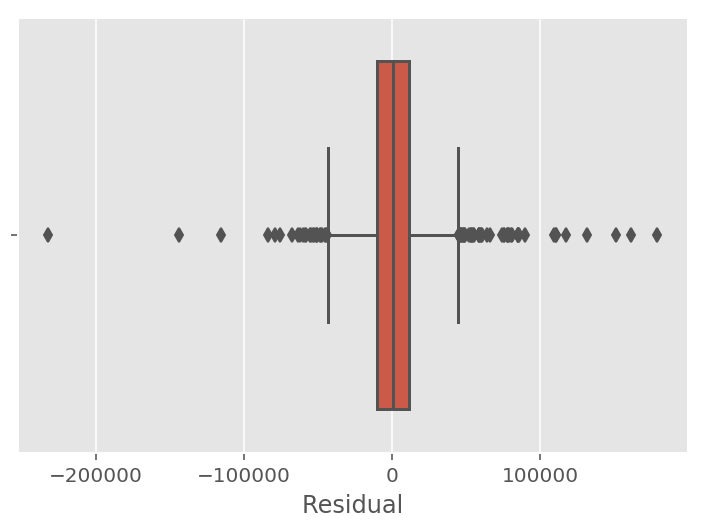

In [51]:
# Sales price outliers
sns.boxplot(house_var['Residual']);

## EDA variable variables

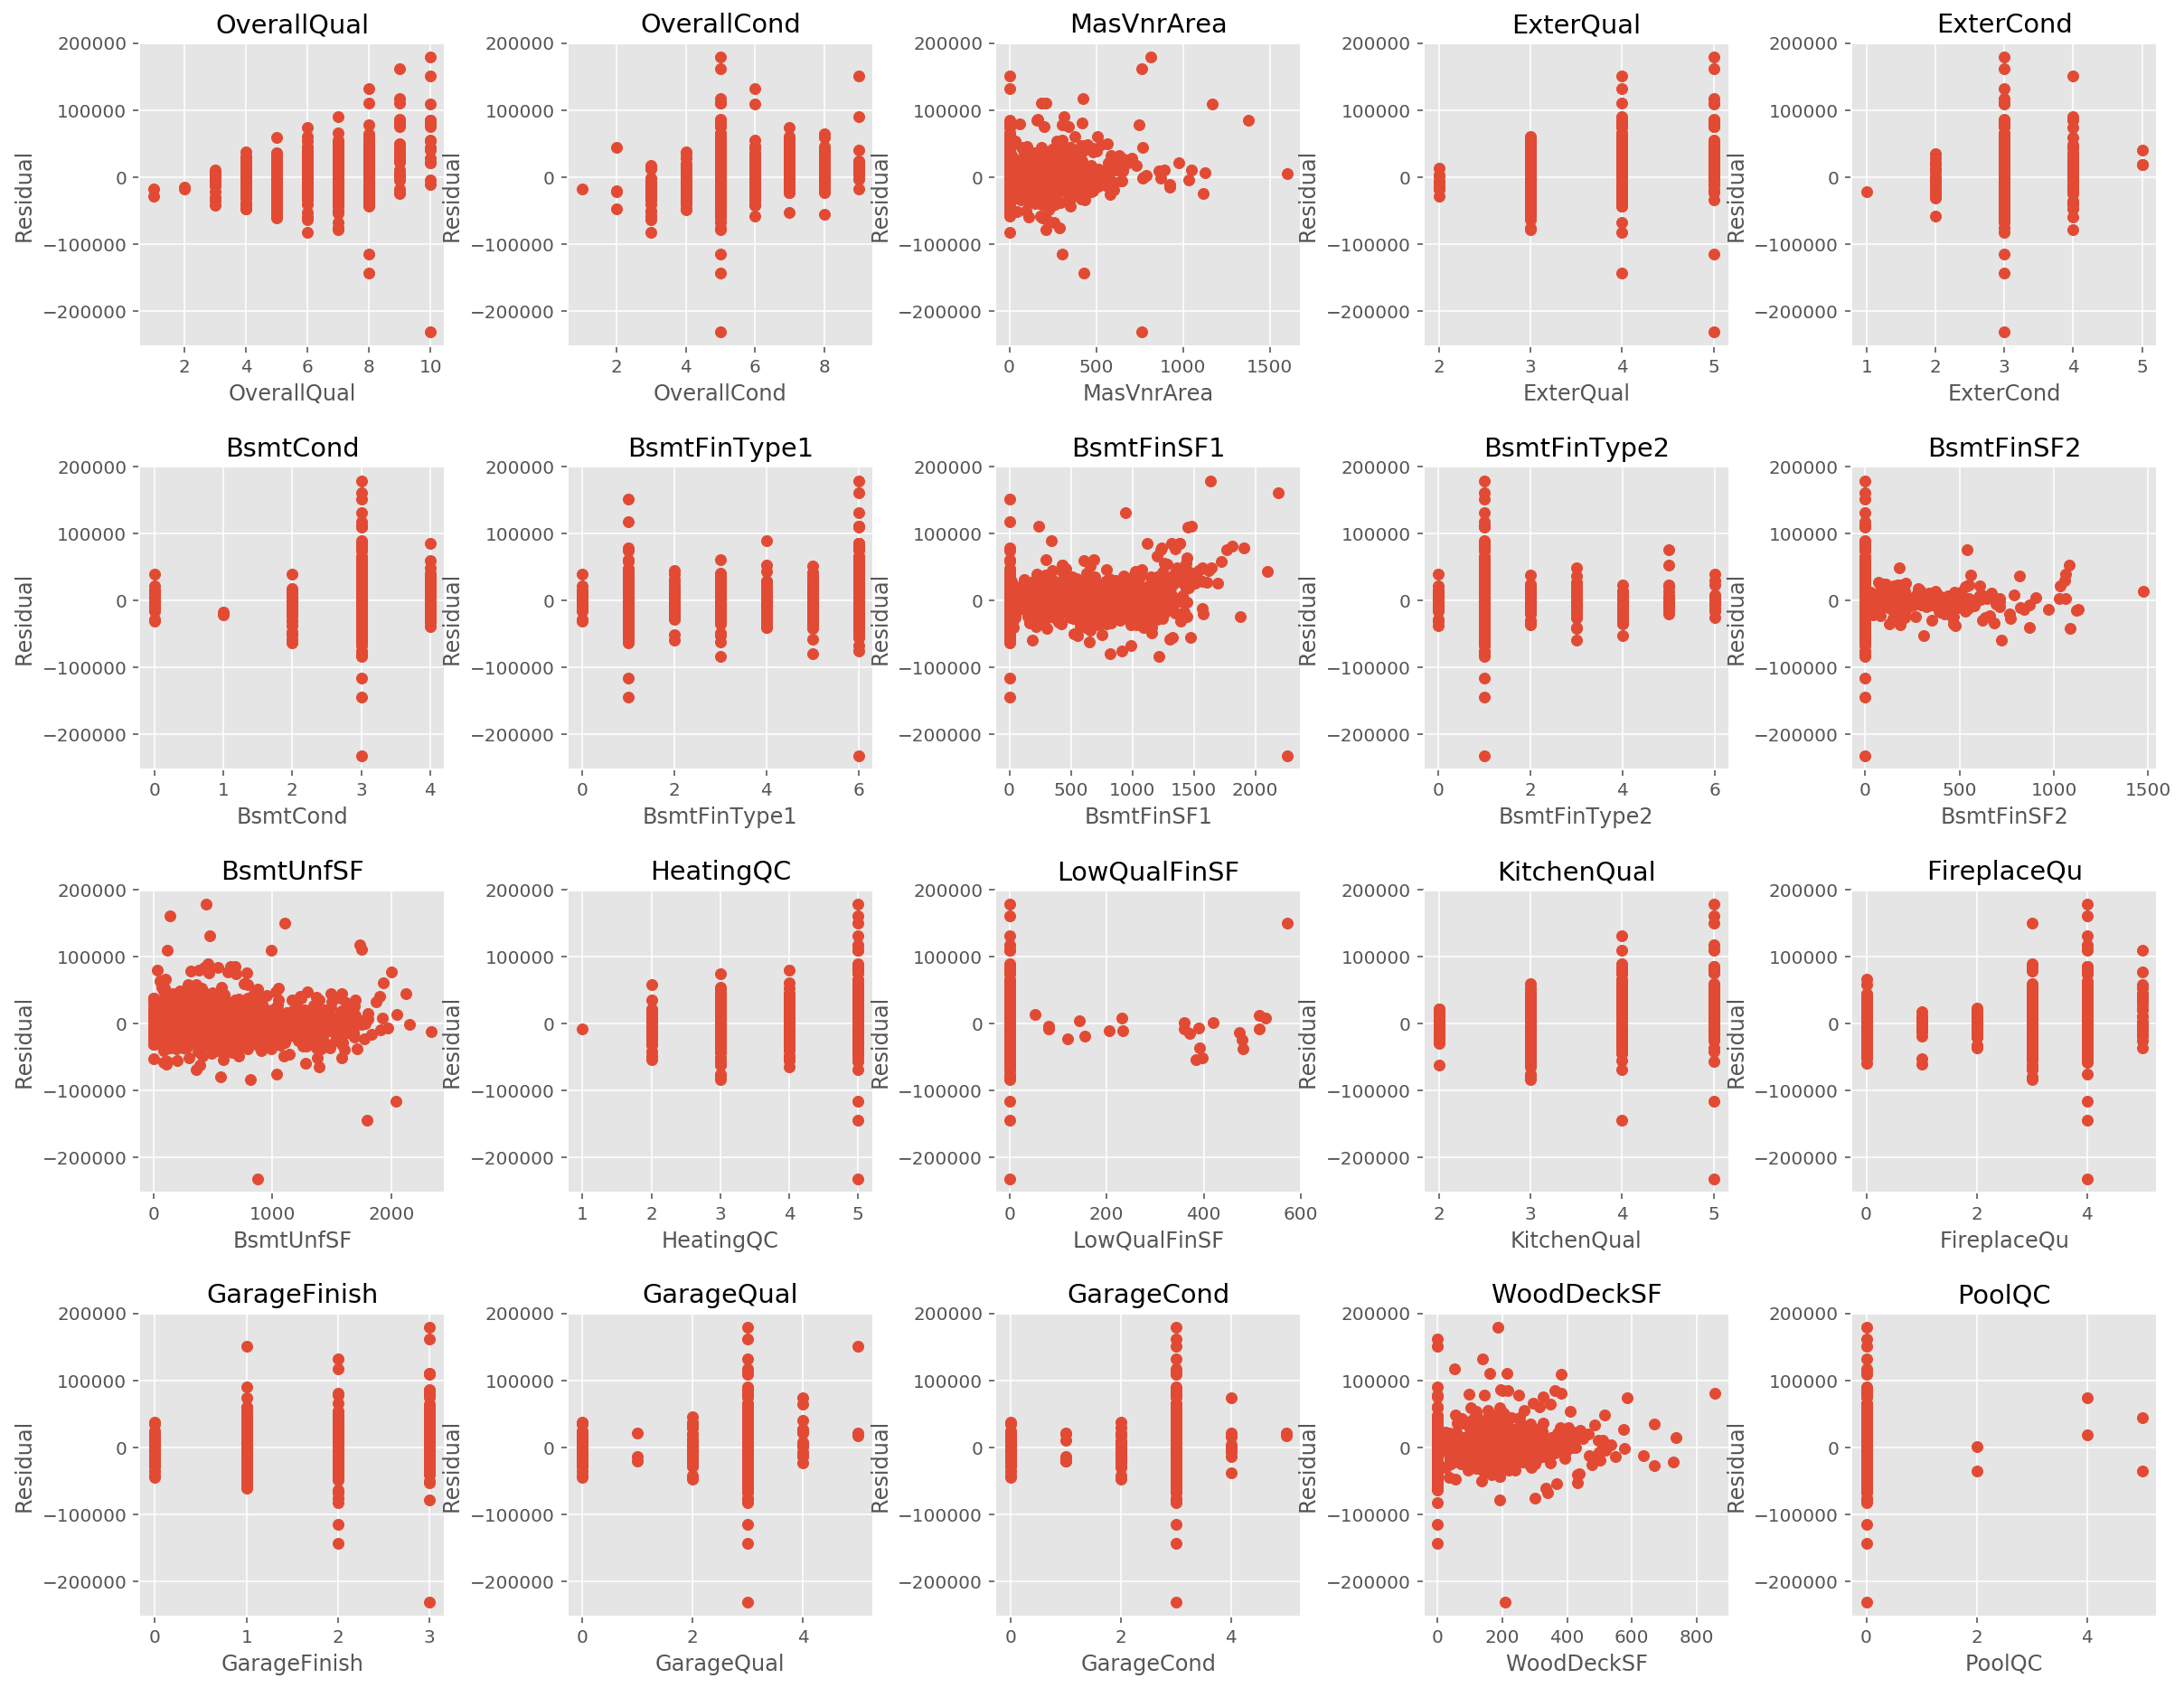

In [52]:
plt_cols=5
plt_rows=int(np.ceil(len(var_cols_no_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,4*plt_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
count=0
for col in var_cols_no_dummy:
    x,y = divmod(count,plt_cols)
    ax[x,y].scatter(y='Residual',x=col,data=house_var)
    ax[x,y].set_ylabel('Residual')
    ax[x,y].set_xlabel(col)
    ax[x,y].set_title(col)
    count+=1
    
plt.show()

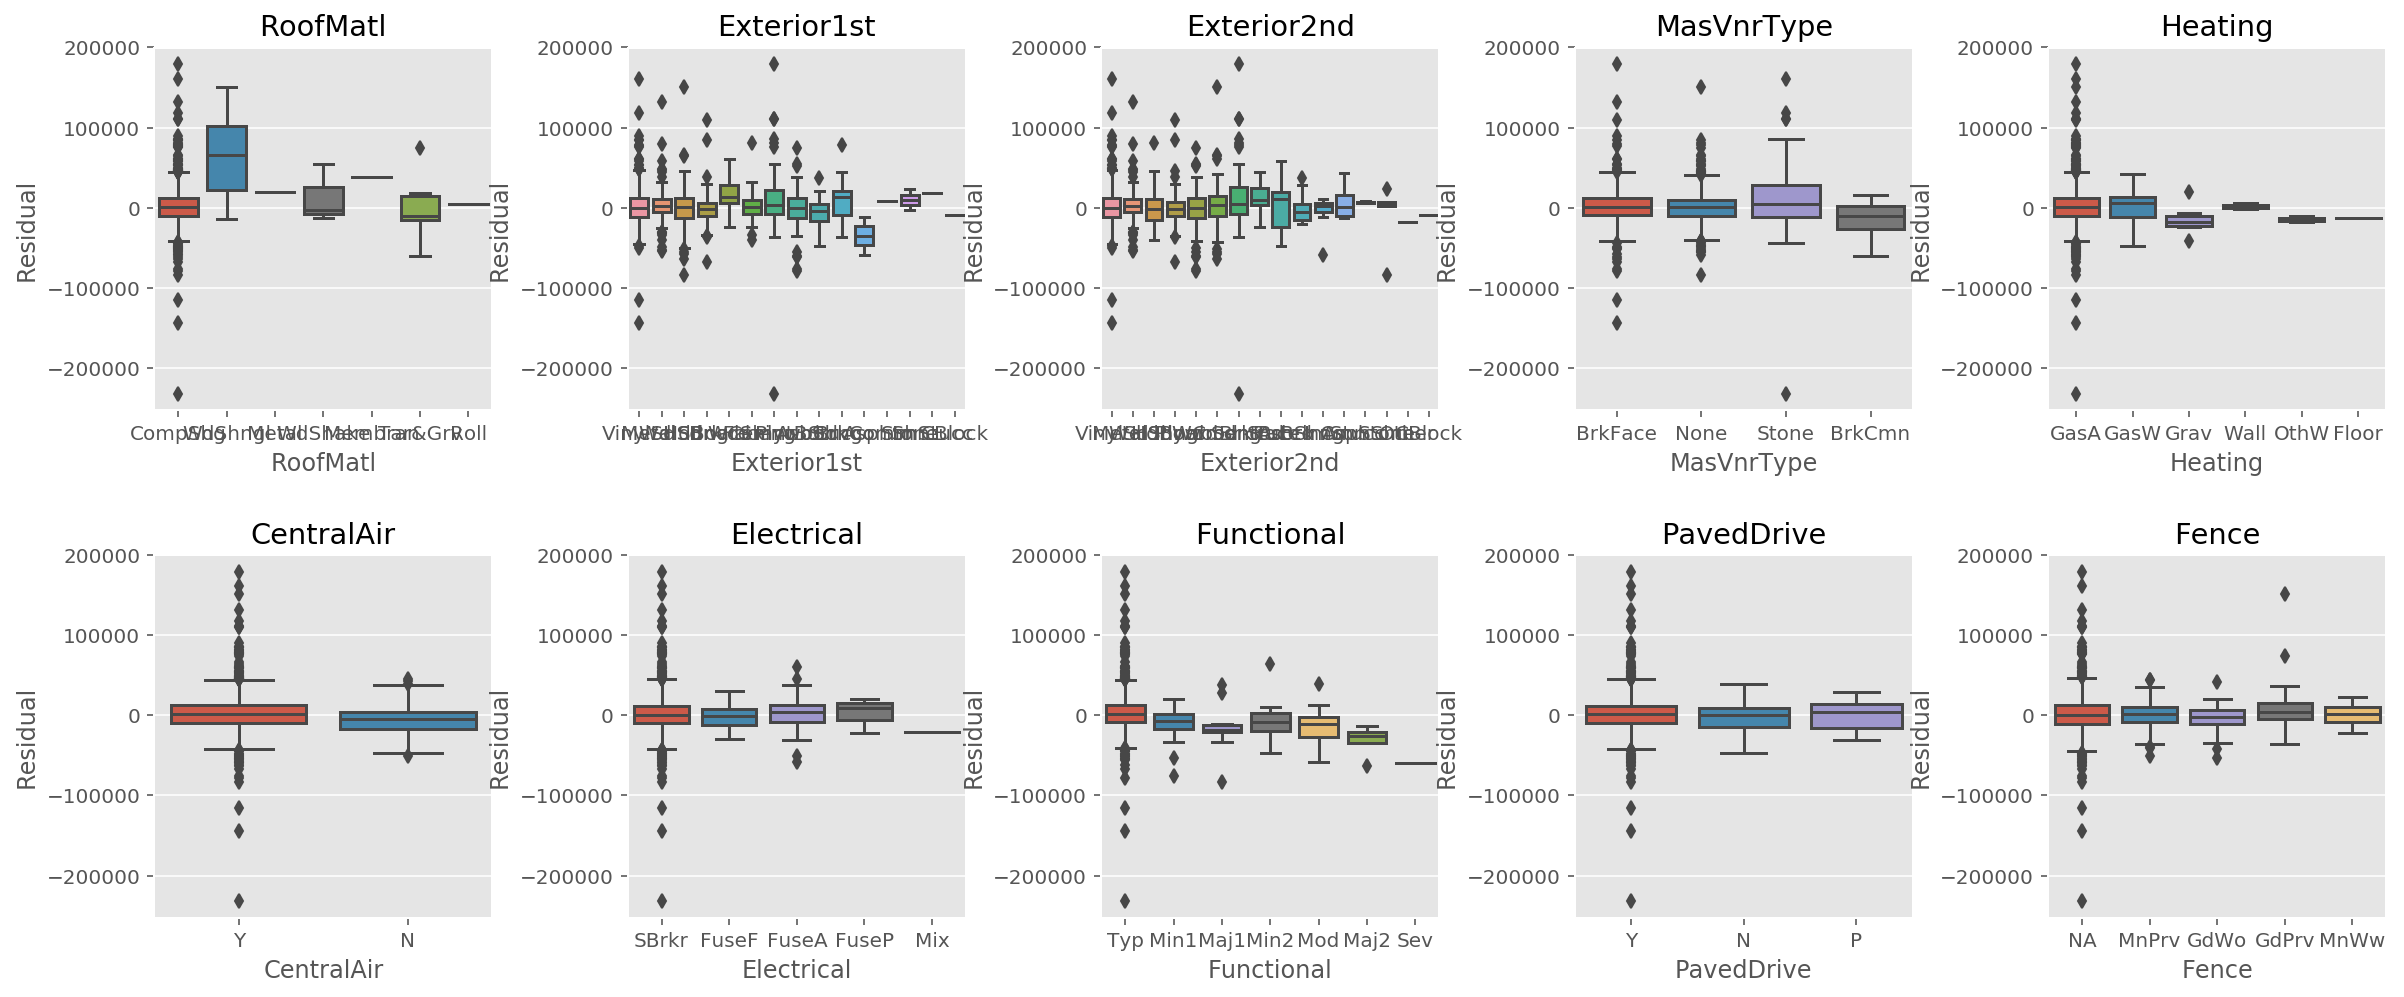

In [53]:
plt_cols=5
plt_rows=int(np.ceil(len(var_cols_to_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,4*plt_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
count=0
for col in var_cols_to_dummy:
    x,y = divmod(count,plt_cols)
    sns.boxplot(x=col,y='Residual', data=house_var,ax=ax[x,y])
    ax[x,y].set_title(col)
    count+=1
    
plt.show()

### Outliers

There is one consistent outlier - the residual less than -$200,000. This will be removed from the data for training the model.

## Prepare data

In [54]:
# Excluse outlier
house_var = house_var[house_var['Residual']>-200000]

In [55]:
X_var = pd.get_dummies(house_var,drop_first=True,columns=var_cols_to_dummy)

X_train_var = X_var[X_var['YrSold']<2010].copy()
X_test_var = X_var[X_var['YrSold']==2010].copy()

X_var.pop('YrSold')
X_train_var.pop('YrSold')
X_test_var.pop('YrSold')

y_var = X_var.pop('Residual')
y_train_var = X_train_var.pop('Residual')
y_test_var = X_test_var.pop('Residual')


In [56]:
kf = KFold(n_splits=8, shuffle=True, random_state=1)

## Model selection

### Attempt #1: no standardisation

Linear regression - no regularisation

In [57]:
lin_reg_model_var = LinearRegression()

lin_reg_model_var_cv_scores = cross_val_score(lin_reg_model_var, X_train_var, y_train_var, cv=kf)

lin_reg_model_var_cv_scores.mean()

0.15057262139954047

Linear regression - Lasso

In [58]:
lin_reg_lassocv_model_var = LassoCV(n_alphas=1000,cv=kf)

lin_reg_lassocv_model_var.fit(X_train_var,y_train_var)

lin_reg_lasso_model_var = Lasso(lin_reg_lassocv_model_var.alpha_)

lin_reg_lasso_model_var_cv_scores = cross_val_score(lin_reg_lasso_model_var, X_train_var, y_train_var, cv=kf)

lin_reg_lasso_model_var_cv_scores.mean()

0.14416089106013838

Linear regression - Ridge

In [59]:
alpha_range = np.logspace(-4, 4, 1000)

lin_reg_ridgecv_model_var = RidgeCV(alphas=alpha_range,cv=kf)

lin_reg_ridgecv_model_var.fit(X_train_var,y_train_var)

lin_reg_ridge_model_var = Ridge(lin_reg_ridgecv_model_var.alpha_)

lin_reg_ridge_model_var_cv_scores = cross_val_score(lin_reg_ridge_model_var, X_train_var, y_train_var, cv=kf)

lin_reg_ridge_model_var_cv_scores.mean()

0.2030535755525359

Linear regression - ElasticNet

In [60]:
l1_ratios = np.linspace(0.001, 1.0, 100)

lin_reg_elnetcv_model_var = ElasticNetCV(n_alphas=100,l1_ratio=l1_ratios,cv=kf)

lin_reg_elnetcv_model_var.fit(X_train_var,y_train_var)

lin_reg_elnet_model_var = ElasticNet(lin_reg_elnetcv_model_var.alpha_)

lin_reg_elnet_model_var_cv_scores = cross_val_score(lin_reg_elnet_model_var, X_train_var, y_train_var, cv=kf)

lin_reg_elnet_model_var_cv_scores.mean()

0.028572865799610478

### Attempt #2: with standardisation

In [61]:
scaler = StandardScaler()

X_train_var_std = scaler.fit_transform(X_train_var)
X_test_var_std = scaler.transform(X_test_var)

Linear regression - no regularisation

In [62]:
lin_reg_model_var_std = LinearRegression()

lin_reg_model_var_cv_std_scores = cross_val_score(lin_reg_model_var_std, X_train_var_std, y_train_var, cv=kf)

lin_reg_model_var_cv_std_scores.mean()

-1.511923526901453e+25

Linear regression - Lasso

In [63]:
lin_reg_lassocv_model_var_std = LassoCV(n_alphas=1000,cv=kf)

lin_reg_lassocv_model_var_std.fit(X_train_var_std,y_train_var)

lin_reg_lasso_model_var_std = Lasso(lin_reg_lassocv_model_var_std.alpha_)

lin_reg_lasso_model_var_cv_std_scores = cross_val_score(lin_reg_lasso_model_var_std, X_train_var_std, y_train_var, cv=kf)

lin_reg_lasso_model_var_cv_std_scores.mean()

0.19792269461013345

Linear regression - Ridge

In [64]:
alpha_range = np.logspace(-4, 4, 1000)

lin_reg_ridgecv_model_var_std = RidgeCV(alphas=alpha_range,cv=kf)

lin_reg_ridgecv_model_var_std.fit(X_train_var_std,y_train_var)

lin_reg_ridge_model_var_std = Ridge(lin_reg_ridgecv_model_var_std.alpha_)

lin_reg_ridge_model_var_cv_std_scores = cross_val_score(lin_reg_ridge_model_var_std, X_train_var_std, y_train_var, cv=kf)

lin_reg_ridge_model_var_cv_std_scores.mean()

0.1791540468484536

Linear regression - ElasticNet

In [65]:
l1_ratios = np.linspace(0.001, 1.0, 100)

lin_reg_elnetcv_model_var_std = ElasticNetCV(n_alphas=100,l1_ratio=l1_ratios,cv=kf,max_iter=5000)

lin_reg_elnetcv_model_var_std.fit(X_train_var_std,y_train_var)

lin_reg_elnet_model_var_std = ElasticNet(lin_reg_elnetcv_model_var_std.alpha_)

lin_reg_elnet_model_var_cv_std_scores = cross_val_score(lin_reg_elnet_model_var_std, X_train_var_std, y_train_var, cv=kf)

lin_reg_elnet_model_var_cv_std_scores.mean()

-0.01120714001896582

In [66]:
print('LinReg with no standardisation:\t',lin_reg_model_var_cv_scores.mean())
print('Lasso with no standardisation:\t',lin_reg_lasso_model_var_cv_scores.mean())
print('Ridge with no standardisation:\t',lin_reg_ridge_model_var_cv_scores.mean())
print('ElNet with no standardisation:\t',lin_reg_elnet_model_var_cv_scores.mean())
print('LinReg with standardisation:\t',lin_reg_model_var_cv_std_scores.mean())
print('Lasso with standardisation:\t',lin_reg_lasso_model_var_cv_std_scores.mean())
print('Ridge with standardisation:\t',lin_reg_ridge_model_var_cv_std_scores.mean())
print('ElNet with standardisation:\t',lin_reg_elnet_model_var_cv_std_scores.mean())

LinReg with no standardisation:	 0.15057262139954047
Lasso with no standardisation:	 0.14416089106013838
Ridge with no standardisation:	 0.2030535755525359
ElNet with no standardisation:	 0.028572865799610478
LinReg with standardisation:	 -1.511923526901453e+25
Lasso with standardisation:	 0.19792269461013345
Ridge with standardisation:	 0.1791540468484536
ElNet with standardisation:	 -0.01120714001896582


### Conclusion

The Linear Regression model with Ridge regularisation based on non-standardised data performed the best.

However, none of the models performed particularly well and should not necessarily be trusted.

### Testing generalisation of model

In [67]:
lin_reg_ridge_model_var.fit(X_test_var,y_test_var)

lin_reg_ridge_model_var_test_score = lin_reg_ridge_model_var.score(X_test_var,y_test_var)

lin_reg_ridge_model_var_test_score

0.28723145320812127

It appears that the model generalises very well, as the r^2 score is higher for the test data than for the training data.

## Fit selected model on whole dataset and determine residuals

In [68]:
lin_reg_ridge_model_var.fit(X_var,y_var)

lin_reg_ridge_model_var_score = lin_reg_ridge_model_var.score(X_var,y_var)

lin_reg_ridge_model_var_score

0.2622159486910871

In [69]:
y_hat_var = lin_reg_ridge_model_var.predict(X_var)

residuals_var = y_var.to_frame()

residuals_var['y_hat_var'] = y_hat_var

residuals_var['residual_var'] = residuals_var['Residual'] - residuals_var['y_hat_var']

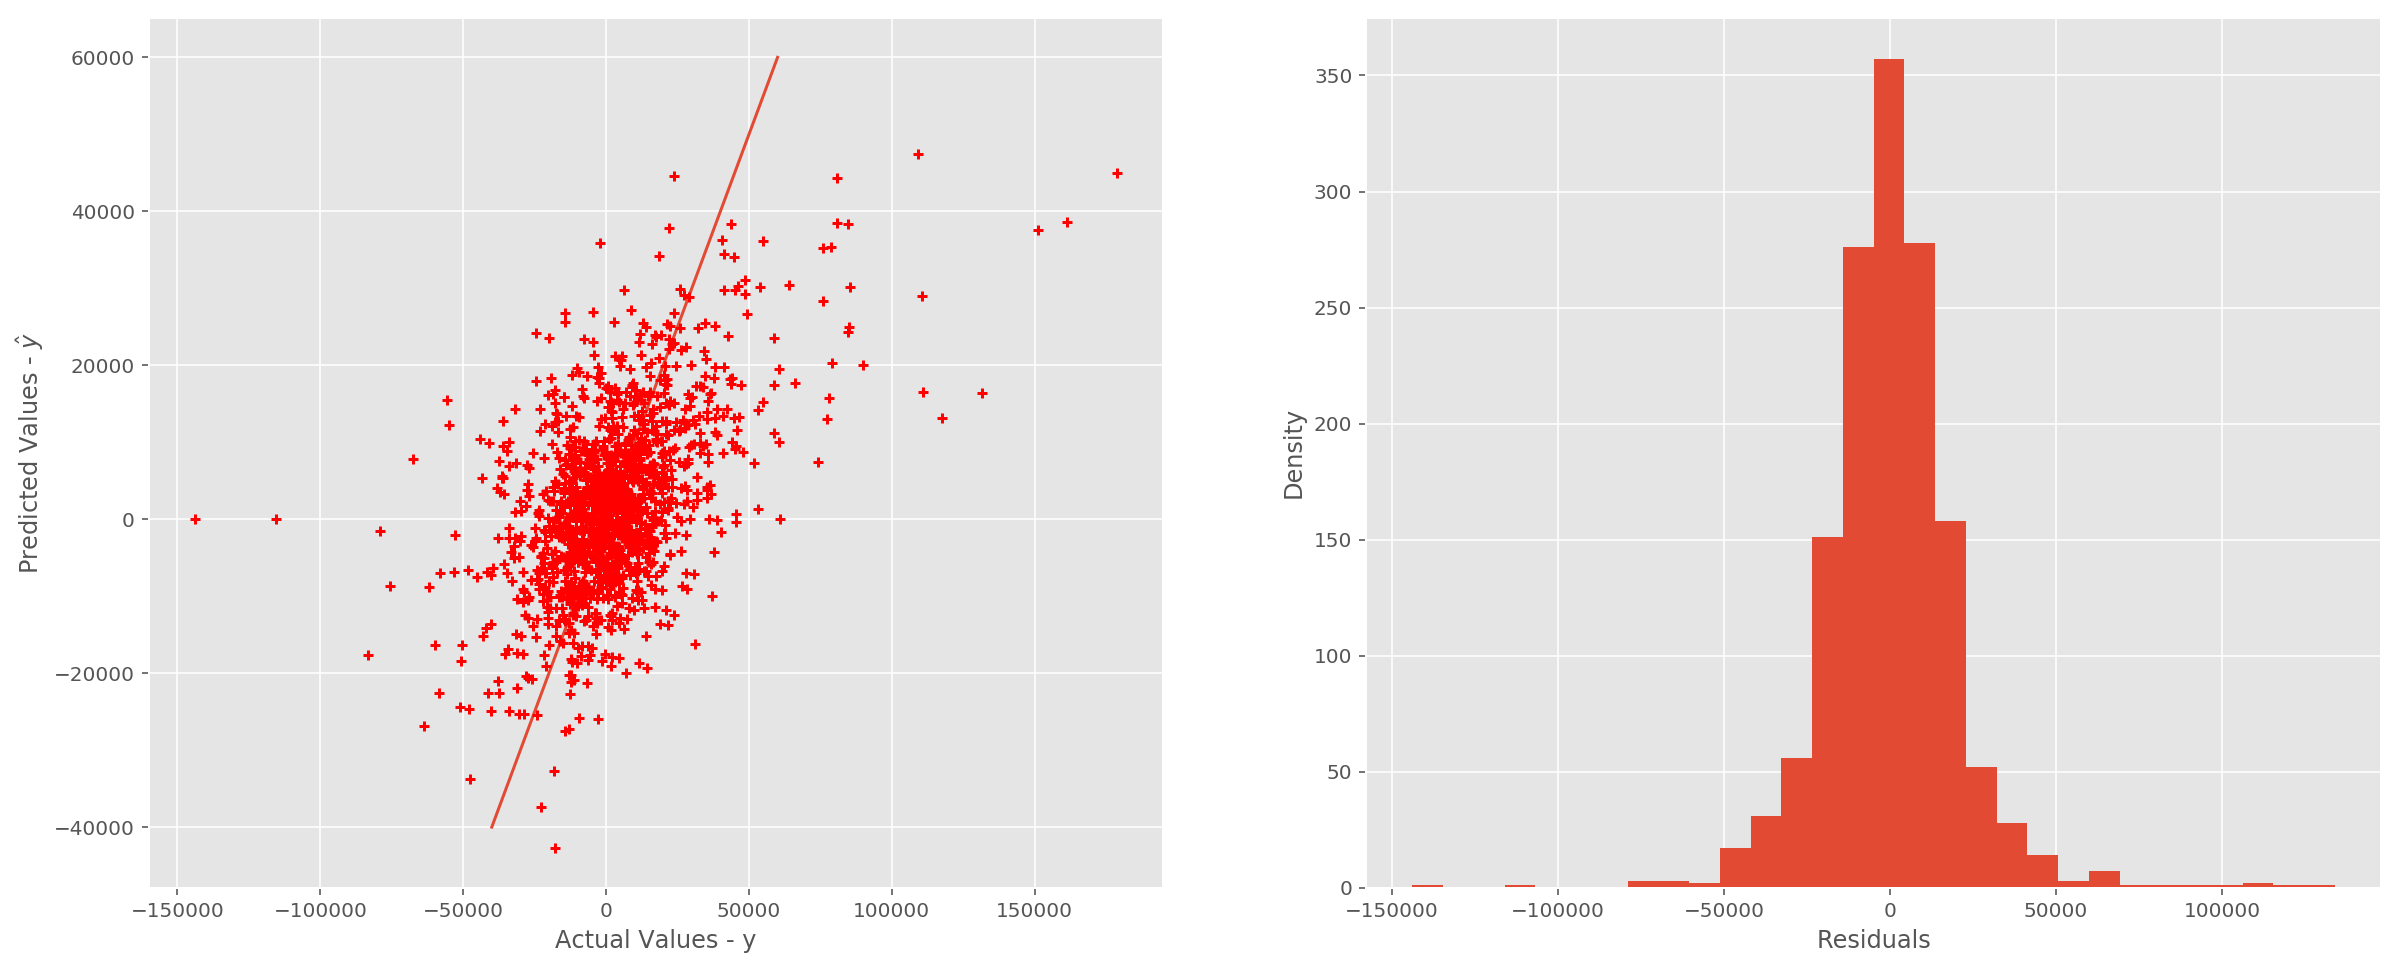

In [70]:
# Plot the predictions
x_plot = pd.DataFrame(np.linspace(-40000,60000))
y_plot = pd.DataFrame(np.linspace(-40000,60000))

fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].scatter(x='Residual', y='y_hat_var', data=residuals_var, s=30, c='r', marker='+', zorder=10)
ax[0].plot(x_plot,y_plot)
ax[0].set_ylabel("Predicted Values - $\hat{y}$")
ax[0].set_xlabel("Actual Values - y")

ax[1].hist(residuals_var['residual_var'],bins=30)
ax[1].set_xlabel("Residuals")
ax[1].set_ylabel("Density")

plt.show()

In [71]:
lin_reg_ridge_model_var.intercept_

-54827.98792979999

In [72]:
lin_reg_ridge_model_var_coef = pd.DataFrame(lin_reg_ridge_model_var.coef_, index=X_var.columns, columns=['Coefs'])

lin_reg_ridge_model_var_coef['Abs_Coef'] = abs(lin_reg_ridge_model_var_coef['Coefs'])

lin_reg_ridge_model_var_coef.sort_values('Abs_Coef',ascending=True,inplace=True)

In [73]:
cat_dummy = pd.get_dummies(house_var[var_cols_to_dummy],drop_first=False,columns=var_cols_to_dummy)

cat_index = cat_dummy.columns

k = [ind for ind in lin_reg_ridge_model_var_coef['Coefs'].index if ind not in var_cols_no_dummy]
bl_list = []
for i in lin_reg_ridge_model_var_coef['Coefs'][cat_index].index:
    bl_list_1 = []
    j = i.split('_')[0]
    if i not in k:
        baseline = i
    bl_list_1.append(j)
    bl_list_1.append(i)
    bl_list_1.append(baseline)
    bl_list.append(bl_list_1)
cat_plot_df = pd.DataFrame(bl_list,columns=['Catgeory','Option','Baseline'])
cat_plot_df = pd.merge(cat_plot_df,lin_reg_ridge_model_var_coef,left_on='Option',right_index=True,how='left')

In [74]:
scale_coefs_df = lin_reg_ridge_model_var_coef['Coefs'][var_cols_no_dummy].copy()
scale_coefs_df.sort_values(inplace=True)
scale_coefs_df.plot(kind='barh',figsize=(12,8),legend=False);

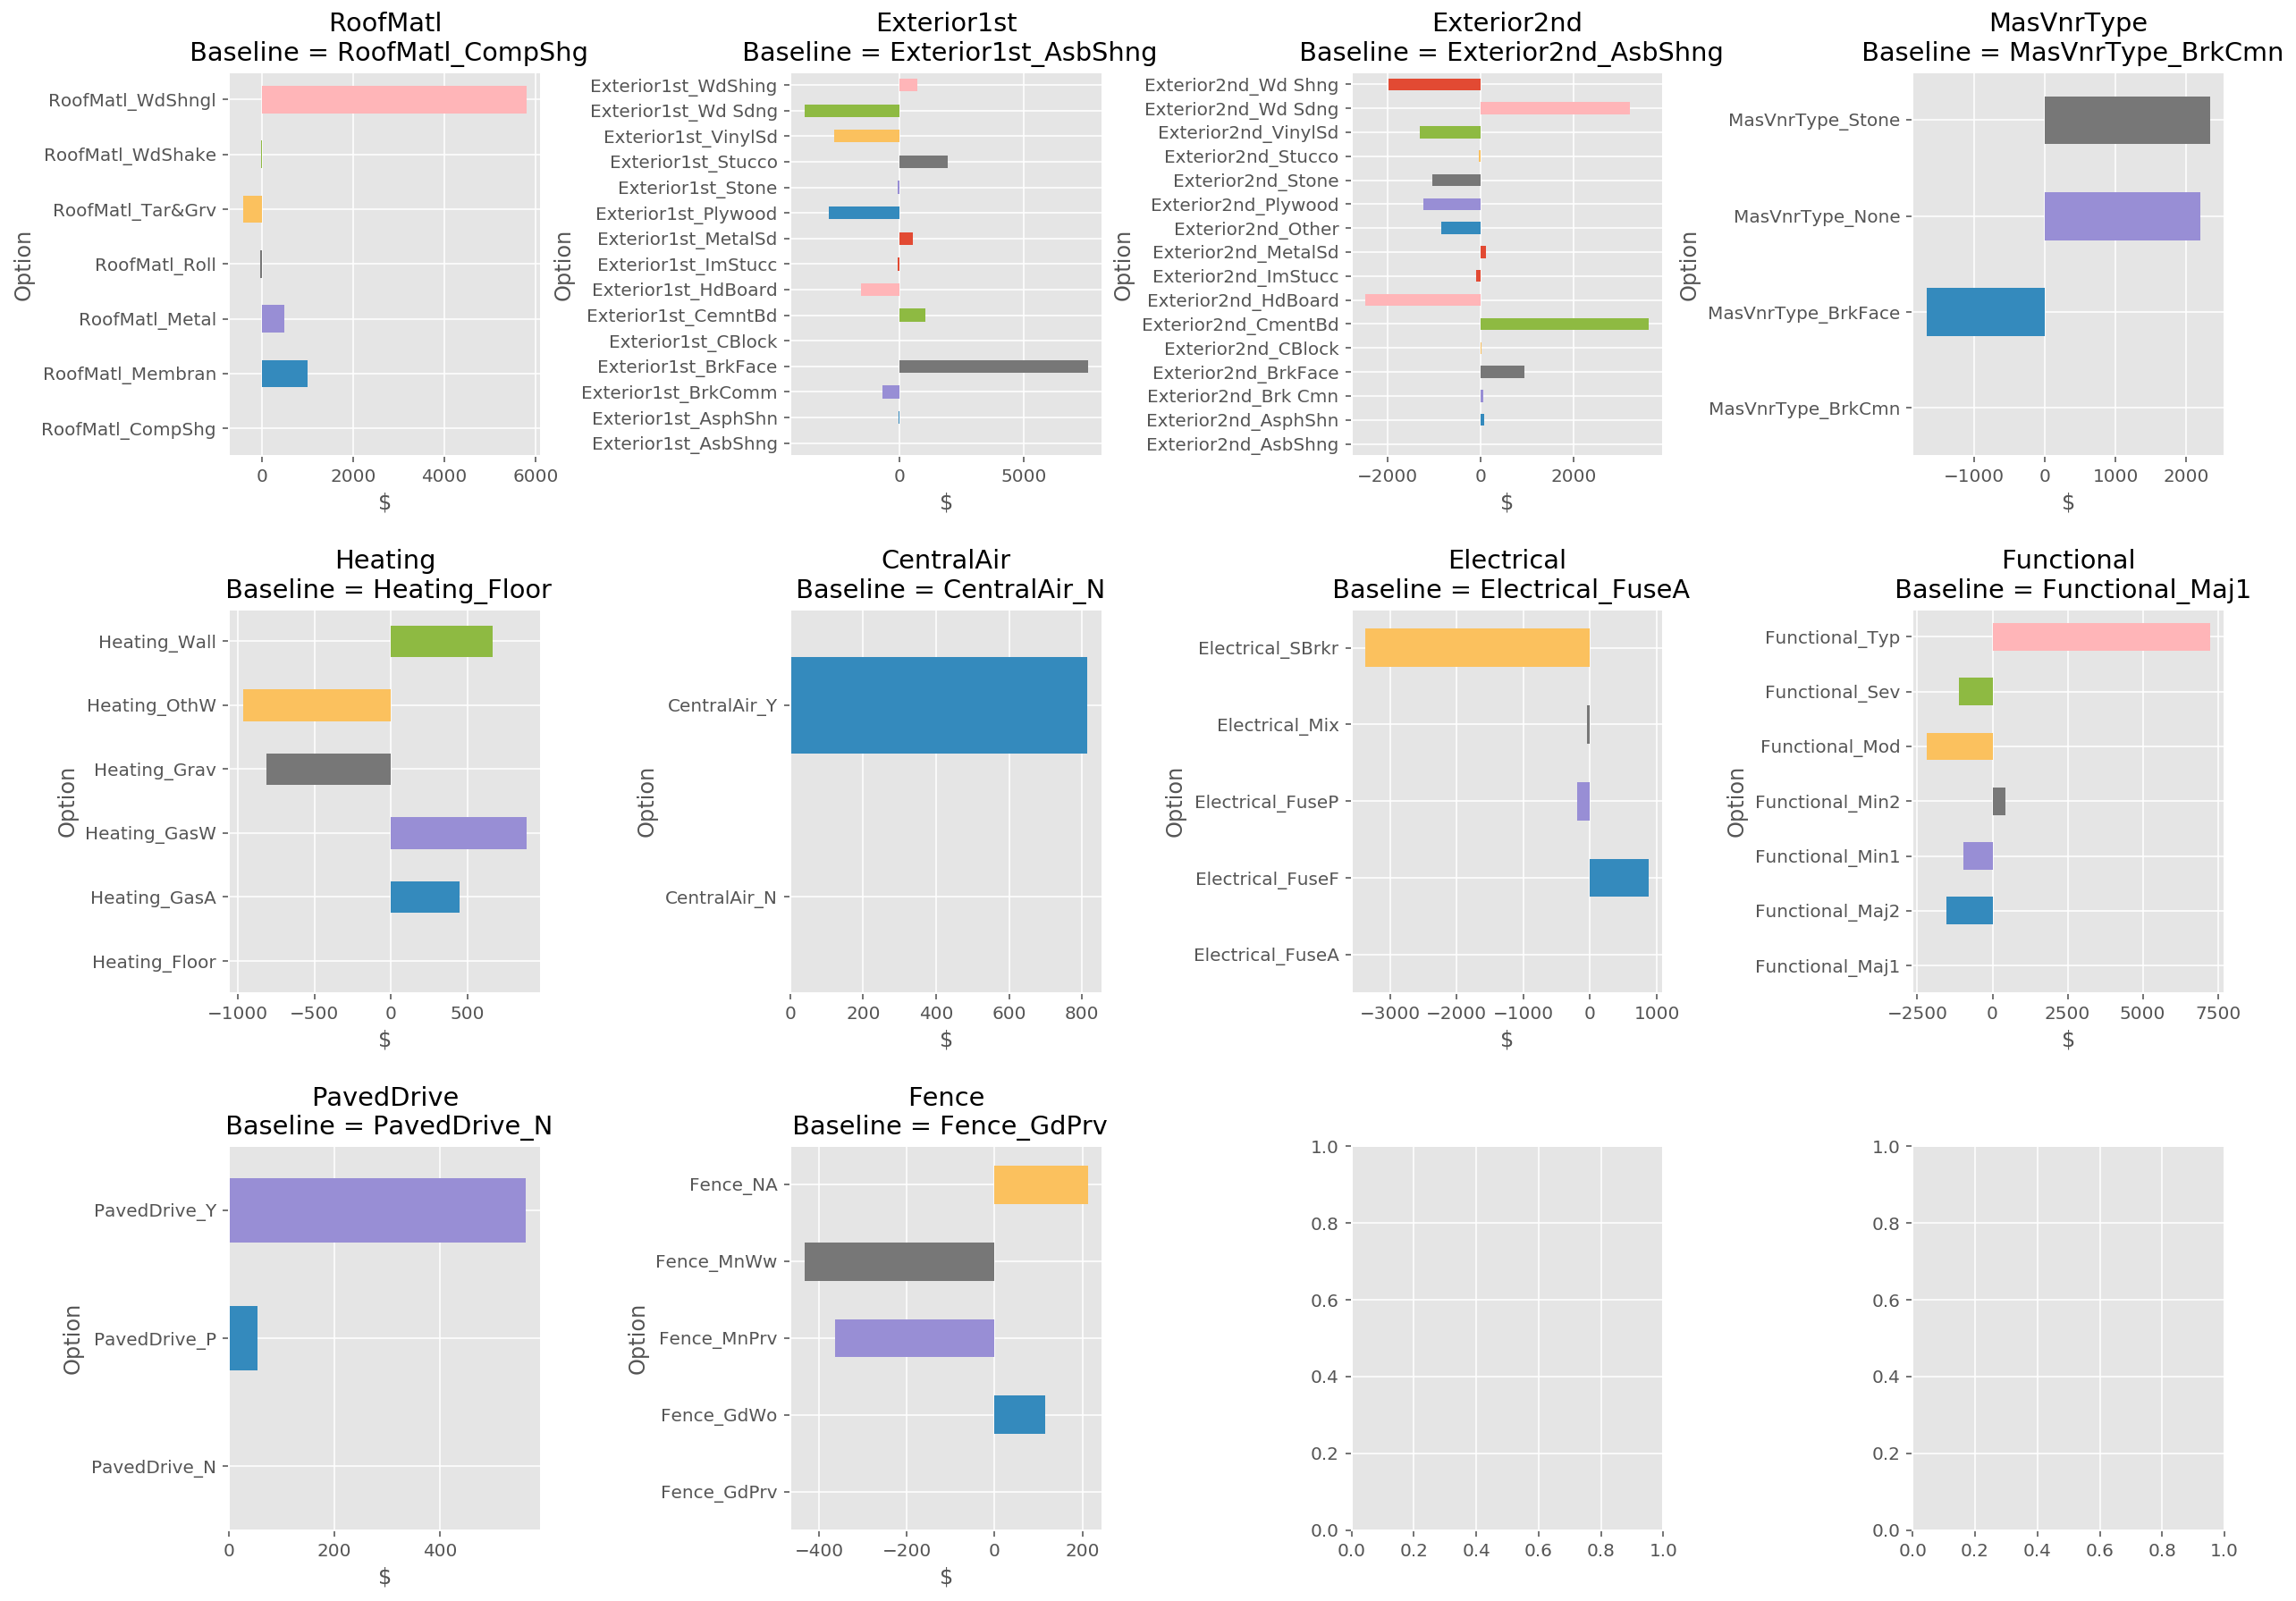

In [75]:
plt_cols=4
plt_rows=int(np.ceil(len(var_cols_to_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,5*plt_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.4)
count=0
for col in var_cols_to_dummy:
    x,y = divmod(count,plt_cols)
    plot_series = pd.DataFrame(cat_plot_df[cat_plot_df['Catgeory']==col])
    plot_series.plot(x='Option',y='Coefs',kind='barh',legend=False,ax=ax[x,y])
    ax[x,y].set_xlabel('$')
    ax[x,y].set_ylabel('Option')
    ax[x,y].set_title('{0}\n Baseline = {1}'.format(col,plot_series['Baseline'].iloc[0]))
    count+=1
    
plt.show()


### Explanation

The overall quality and condition of the property have the largest positive impact on price based on the variable characteristics identified.

For every additional point on the overall quality scale (i.e. moving from average to good) would add nearly \$6,000 to the value of the property, with overall quality adding nearly \$5,000.

In addition, there are some features that, if present in the original property, could be amended to increase the value of the house dramatically. One example is changing the Exterior from Wood Siding to Brick Face, which would add nearly \$10,000 to the value of the house.

### How these two models can be used

In order to determine whether money can be made from a property, firstly the data for fixed items should be used in the first model to determine if the sale price for the house is in line with (and ideally below) the forecast value based on location, size etc.

If the sale price is below the forecast value, the next step is to determine what renovations should be made. This is determined by identifying the options for refurbishment and the associated costs of those refurbishments, and then comparing that to the estimated return from doing those refurbishments.

If the estimated return for the refurbishments exceeds the costs of completing the work then profit could be made.

However, it is worth noting that the second model is not very accurate and should not be relied upon.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

## Oversampling

To reduce the impact of class imbalance, one option is to create more balance by duplicating the minority class until they make up a significant proportion of the overall data set.

This prevents loss of data from creating balance by reducing the number of items in the majority class but has much greater propensity for overfitting to the data.

In [76]:
house['SaleCondition'].value_counts()

Normal     1192
Partial     124
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [77]:
sum([1 if i == "Abnorml" else 0 for i in house['SaleCondition']])/len(house['SaleCondition'])

0.0663441603317208

The abnormal category only makes up 6.6% of the total number of rows in the data. To reduce the imbalance, 5 additional copies of these rows will be added.

In [78]:
# Add 5 copies of abnorml_house
abnorml_house = house[house['SaleCondition']=='Abnorml']

house_ab_bal = house.copy()

for i in range(0,5):
    house_ab_bal = pd.concat([house_ab_bal,abnorml_house],axis=0)

In [79]:
sum([1 if i == "Abnorml" else 0 for i in house_ab_bal['SaleCondition']])/len(house_ab_bal['SaleCondition'])

0.29891022314478466

In [80]:
# Create y and X
house_ab_bal['SaleCondition'] = house_ab_bal['SaleCondition'].map(lambda x: 1 if x == "Abnorml" else 0)

X_ab = house_ab_bal
X_ab.pop('Id')
X_ab.pop('SalePrice')

y_ab = X_ab.pop('SaleCondition')

Exclude ID (as not relevant) and Sale Price (as assuming no sale would have happened)

In [81]:
# Dummify X
cols_to_dummy = []
cols_no_dummy = []
for key,val in characteristic_dict.items():
    if key not in ['SaleCondition','Id','SalePrice']:
        if val['Dummy'] == 'Y':
            cols_to_dummy.append(key)
        else:
            cols_no_dummy.append(key)
len(cols_to_dummy)

30

In [82]:
X_ab_dum = pd.get_dummies(X_ab,drop_first=True,columns=cols_to_dummy)

In [83]:
# Standardise X
scaler_ab = StandardScaler()
X_ab_std = scaler_ab.fit_transform(X_ab_dum)

In [84]:
# Train test split
X_train_ab_std, X_test_ab_std, y_train_ab, y_test_ab = train_test_split(X_ab_std, y_ab, test_size=0.3, random_state=1)

### Logistic Regression

In [85]:
# Baseline
lr_baseline = y_ab.value_counts(normalize=True).max()
lr_baseline

0.7010897768552153

In [86]:
# fill dictionary of parameters
gs_params = {'penalty': ['l1','l2'],
            'solver': ['liblinear'],
            'C': np.logspace(-3,0,50)}

# create gridsearch object
lr_gridsearch = GridSearchCV(LogisticRegression(),
                              gs_params,
                              n_jobs=-1, cv=5, verbose=1)

In [87]:
# fit gridsearch object on training data
lr_gridsearch.fit(X_train_ab_std, y_train_ab)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223...18, 0.32375,
       0.37276, 0.42919, 0.49417, 0.56899, 0.65513, 0.75431, 0.86851,
       1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [88]:
lr_gridsearch.best_score_

0.8605341246290801

In [89]:
lr_gridsearch.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [90]:
best_lr = lr_gridsearch.best_estimator_

In [91]:
best_lr.score(X_test_ab_std,y_test_ab)

0.8497409326424871

In [92]:
best_lr_coefficients = pd.DataFrame(best_lr.coef_.T,index=X_ab_dum.columns,columns=['Coefs'])

In [93]:
best_lr_coefficients['Abs_Coefs'] = abs(best_lr_coefficients['Coefs'])

In [94]:
best_lr_coefficients.sort_values('Abs_Coefs',inplace=True,ascending=False)

In [95]:
best_lr_coefficients.head()

Coefs  Abs_Coefs
SaleType_New       -2.067233   2.067233
SaleType_WD        -1.784230   1.784230
MasVnrType_None    -1.571088   1.571088
MasVnrType_BrkFace -1.278328   1.278328
PoolQC              1.180128   1.180128

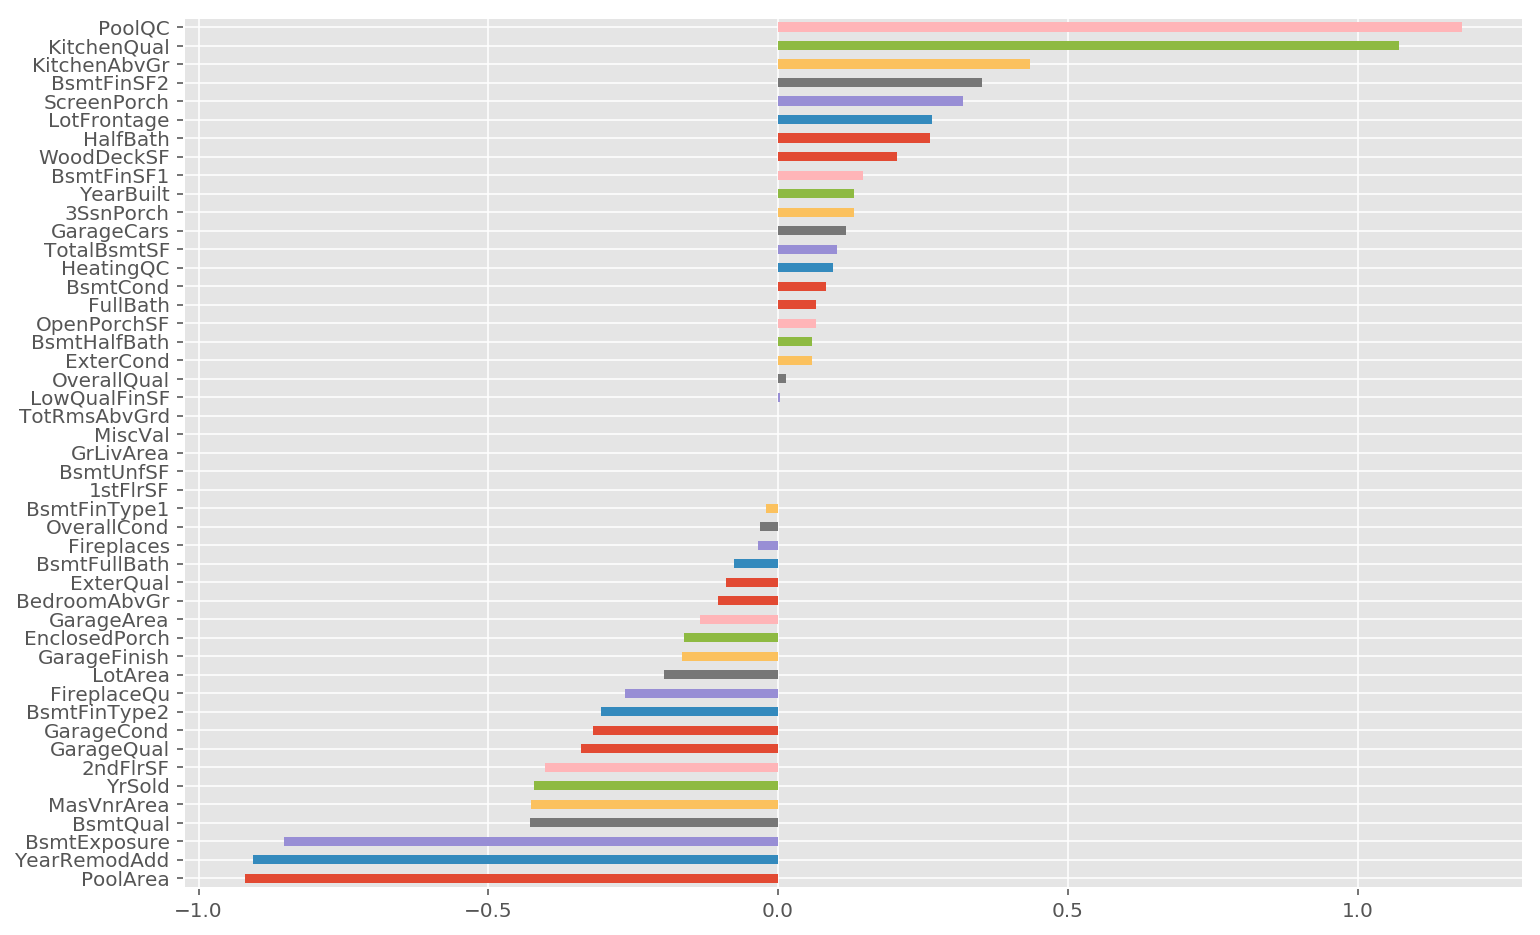

In [96]:
lr_scale_coefs_df = best_lr_coefficients['Coefs'][cols_no_dummy].copy()
lr_scale_coefs_df.sort_values(inplace=True)
lr_scale_coefs_df.plot(kind='barh',figsize=(12,8),legend=False);

In [97]:
lr_cat_dummy = pd.get_dummies(X_ab,drop_first=False,columns=cols_to_dummy)

lr_cat_index = lr_cat_dummy.columns

lr_k = [ind for ind in best_lr_coefficients['Coefs'].index if ind not in cols_no_dummy]
lr_bl_list = []
for i in lin_reg_ridge_model_var_coef['Coefs'][lr_cat_index].index:
    bl_list_1 = []
    j = i.split('_')[0]
    if i not in lr_k:
        baseline = i
    bl_list_1.append(j)
    bl_list_1.append(i)
    bl_list_1.append(baseline)
    lr_bl_list.append(bl_list_1)
lr_cat_plot_df = pd.DataFrame(lr_bl_list,columns=['Catgeory','Option','Baseline'])
lr_cat_plot_df = pd.merge(lr_cat_plot_df,best_lr_coefficients,left_on='Option',right_index=True,how='left')

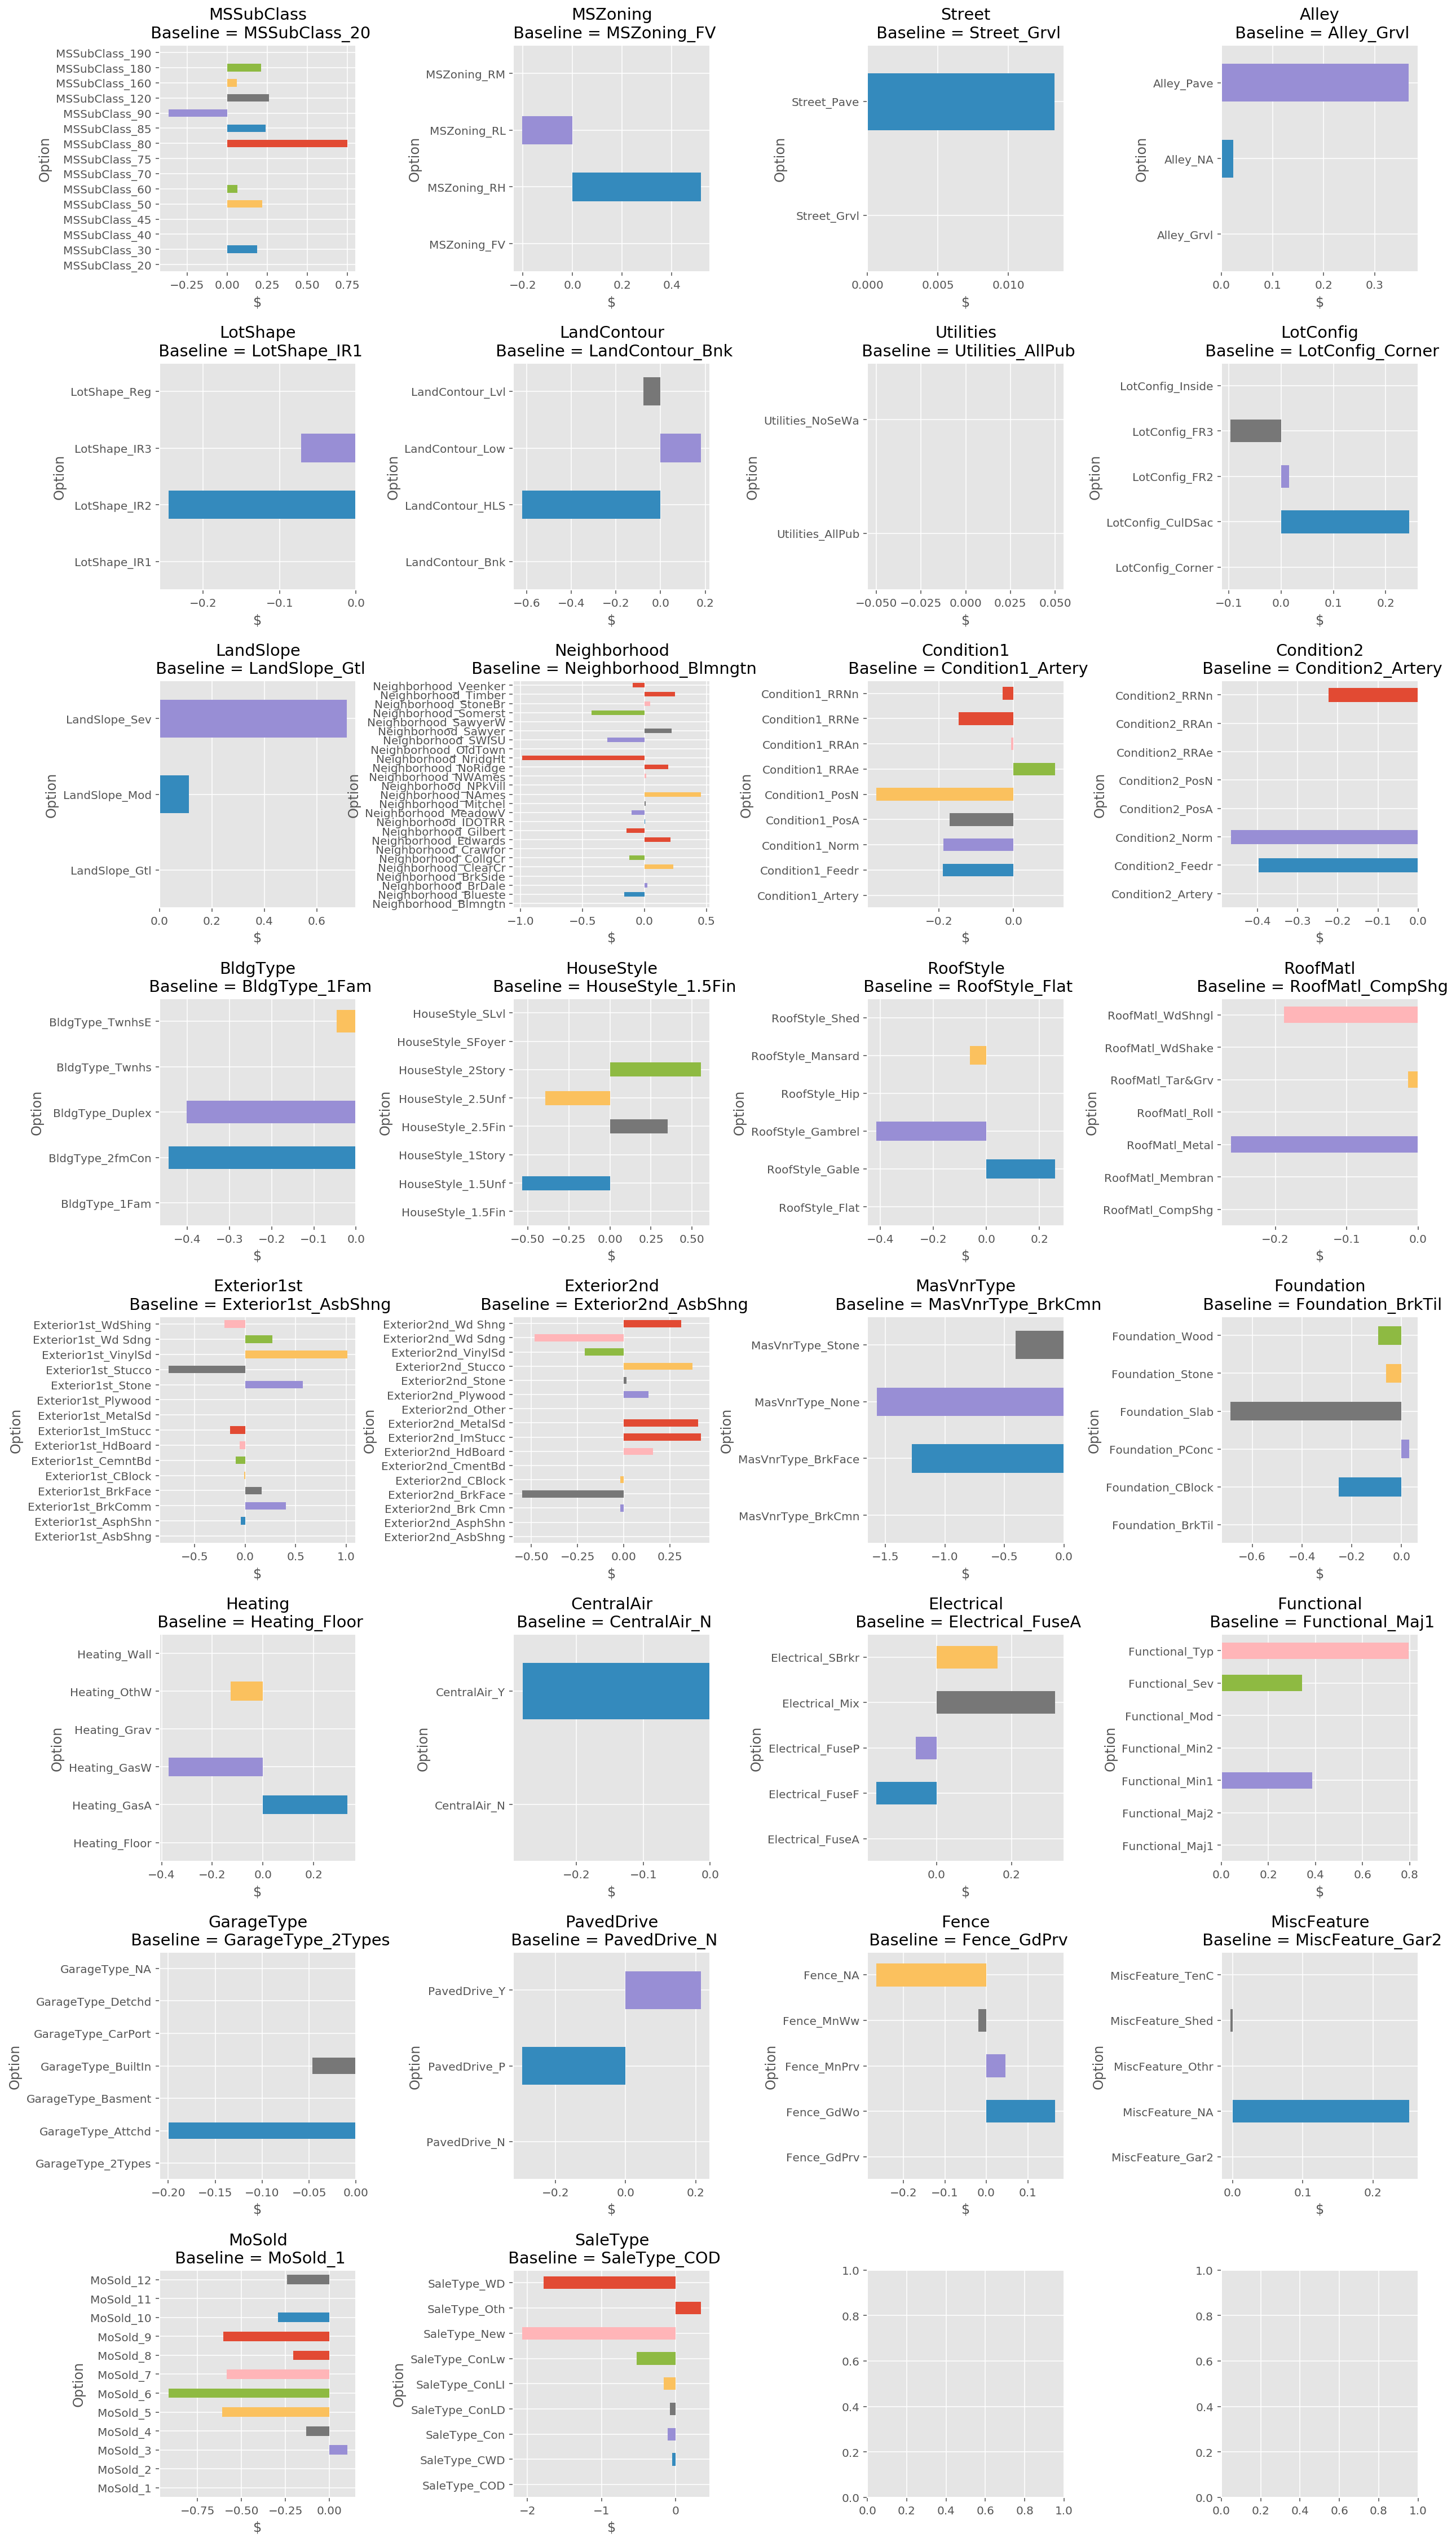

In [98]:
plt_cols=4
plt_rows=int(np.ceil(len(cols_to_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,5*plt_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.4)
count=0
for col in cols_to_dummy:
    x,y = divmod(count,plt_cols)
    plot_series = pd.DataFrame(lr_cat_plot_df[lr_cat_plot_df['Catgeory']==col])
    plot_series.plot(x='Option',y='Coefs',kind='barh',legend=False,ax=ax[x,y])
    ax[x,y].set_xlabel('$')
    ax[x,y].set_ylabel('Option')
    ax[x,y].set_title('{0}\n Baseline = {1}'.format(col,plot_series['Baseline'].iloc[0]))
    count+=1
    
plt.show()


### Analysis

Sale type seems to have the largest impact on whether a sale would be abnormal. However, I am not sure whether this would be known prior to the sale (and therefore whether it should be excluded from the model). This would have to be confirmed with someone with industry knowledge.

Other than that, the Masonry Veneer Type and the Pool Quality appear to have the largest impacts.

### KNN - Alternative model - no ability to identify key characteristics

The KNN model does not have any coefficients and therefore is unable to identify which factors have the biggest impact. However, it is an alternative classification model and, if it performs well, could be used to predict abnormal sales.

In [99]:
# KNN
knn_baseline = y_ab.value_counts(normalize=True).max()
knn_baseline

0.7010897768552153

In [100]:
knn_params = {
    'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}

In [101]:
knn_ab = KNeighborsClassifier(n_neighbors=5)


In [102]:
knn_gridsearch = GridSearchCV(knn_ab,
                              knn_params,
                              n_jobs=-1, cv=5, verbose=1)

In [103]:
knn_gridsearch.fit(X_train_ab_std, y_train_ab)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   35.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [5, 9, 15, 25, 40, 50, 60], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [104]:
knn_gridsearch.param_grid

{'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
 'weights': ['uniform', 'distance'],
 'metric': ['euclidean', 'manhattan']}

In [105]:
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 60, 'weights': 'distance'}

In [106]:
knn_gridsearch.best_score_

0.9851632047477745

In [107]:
knn_ab_best = knn_gridsearch.best_estimator_

In [108]:
knn_ab_best.score(X_test_ab_std,y_test_ab)

0.9844559585492227

In [109]:
# Confusion matrix

knn_ab_best_predict = knn_ab_best.predict(X_ab_std)

knn_ab_confusion_arr = np.array(confusion_matrix(y_ab,knn_ab_best_predict,labels=[1,0]))
knn_ab_confusion = pd.DataFrame(knn_ab_confusion_arr, index=['Abnormal','Not abnormal'],
                               columns=['Predicted abnormal','Predicted not abnormal'])
knn_ab_confusion

Predicted abnormal  Predicted not abnormal
Abnormal                     576                       0
Not abnormal                   9                    1342

### Analysis

The KNN model appears to be very good at predicting abnormal sales (and is quite easily explained to non-technical users). It may be a viable alternative to forecasting abnormal sales even if there is no way to identify specific factors that cause a sale to be abnormal.